# 1. Импорт библиотек

In [189]:
import numpy as np
import pandas as pd
import pandas_ta as ta
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
from datetime import timedelta, datetime
import os
from joblib import Parallel, delayed
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score, roc_auc_score, precision_recall_curve, precision_recall_curve, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif
import shap
from ipywidgets import widgets
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from IPython.display import display

from modules.create_df import kline_candles
from modules.all_kline_changes import add_target_column, add_target_column_mod, add_target_column_simple
from modules.indicators import delta_ema, macd_cross, delta_atr, delta_ema_volume, delta_macd, regression_slope_price, regression_slope_volume, delta_rsi, ema_above_price, ema_speed, rsi_speed

# 2. Загрузка данных

## 2.1. Загрузка данных с Bybit

Функция **kline_candles** принимает на вход наименование токена **simbol**, таймфрейм **tf**, начало и конец периода для загрузки **start/end**\
На выходе выдает df с данными грфика **Date, Close, Open, Low, High, Volume.**\
Базовые отрезки для:
- обучающей выборки **start** ='2022-03-10 00:00', **end** ='2024-12-09 21:00'
- тестовой выборки **start** = '2024-12-11 00:00', **end** ='2025-07-11 00:00'

In [66]:
df = kline_candles(symbol='LINKUSDT', tf=1, start='2022-03-10 00:00', end='2022-03-12 00:00')
df_test = kline_candles(symbol='LINKUSDT', tf=1, start='2024-12-11 00:00', end='2024-12-12 00:00')

In [67]:
df.head(5)

,Date,Open,High,Low,Close,Volume
0,2022-03-09 21:01:00,13.838,13.838,13.817,13.823,1386.0
1,2022-03-09 21:02:00,13.823,13.855,13.823,13.855,853.7
2,2022-03-09 21:03:00,13.855,13.855,13.849,13.855,154.0
3,2022-03-09 21:04:00,13.855,13.855,13.854,13.855,110.2
4,2022-03-09 21:05:00,13.855,13.905,13.855,13.881,2832.9


## 2.2. Сохранение данных в .csv файл

In [50]:
df.to_csv("downloads/LINKUSDT_m1_train_raw_data.csv", index=False, compression='zstd')
df_test.to_csv("downloads/LINKUSDT_m1_test_raw_data.csv", index=False, compression='zstd')

In [137]:
df.to_csv("downloads/LINK_train_m1_base_features.csv", index=False, compression='zstd')
df_test.to_csv("downloads/LINK_test_m1_base_features.csv", index=False, compression='zstd')

## 2.3. Загрузка df из .csv файла

In [10]:
df= pd.read_csv('downloads/LINKUSDT_m1_train_raw_data.csv', compression='zstd')
df_test = pd.read_csv('downloads/LINKUSDT_m1_test_raw_data.csv', compression='zstd')
df.head(3)

,Open,High,Low,Close,Volume,Date,target
0,13.838,13.838,13.817,13.823,1386.0,2022-03-09 21:01:00,0
1,13.823,13.855,13.823,13.855,853.7,2022-03-09 21:02:00,0
2,13.855,13.855,13.849,13.855,154.0,2022-03-09 21:03:00,0


In [150]:
df= pd.read_csv('downloads/LINK_train_m1_base_features.csv', compression='zstd')
df_test = pd.read_csv('downloads/LINK_test_m1_base_features.csv', compression='zstd')
df.head(3)

,block1_ema20_rel_change,ema20_speed_10,block3_ema20_rel_change,block4_ema20_rel_change,block2_ema20_rel_change,price_slope_5,block1_rsi21_mean,block1_ema50_rel_change,block4_ema50_rel_change,ema20_speed_30,...,ema50_speed_10,ema100_speed_10,block1_rsi21_rel_change,Date,High,Low,Close,Open,Volume,target
0,0.001151,-0.000290,0.001160,0.000122,0.002314,0.000213,40.019915,0.000834,-0.000006,0.000018,...,-0.000086,0.000008,-0.106163,2022-03-10 00:40:00,13.984,13.981,13.984,13.982,28.3,0
1,0.000803,-0.000261,0.001260,0.000394,0.002291,0.000496,41.663476,0.000704,0.000111,0.000015,...,-0.000083,0.000008,-0.170419,2022-03-10 00:41:00,14.020,13.984,14.020,13.984,97.1,0
2,0.000442,-0.000221,0.001344,0.000797,0.002128,0.000595,43.531934,0.000559,0.000288,0.000009,...,-0.000073,0.000011,-0.191528,2022-03-10 00:42:00,14.025,14.016,14.016,14.020,249.4,0


# 3. Формирование целевой переменной

Целевая переменная для функции **add_target_column** - рост цены на **target%** за **target_candles** свечей с соотношением риск / прибыль **rr_threshold**

In [14]:
df = df.drop('target',axis=1)
df_test = df_test.drop('target',axis=1)

In [16]:
df = add_target_column(df, target_candles=30, target=0.01, rr_threshold=2.0)
df_test = add_target_column(df_test, target_candles=30, target=0.01, rr_threshold=2.0)

Целевая переменная для функции **add_target_column_simple** - рост цены на **target%** за **target_candles** свечей

In [18]:
df = add_target_column_simple(df, target_candles=5, target=0.005)
df_test = add_target_column_simple(df_test, target_candles=5, target=0.005)

In [17]:
df.head(3)

,Open,High,Low,Close,Volume,Date,target
0,13.838,13.838,13.817,13.823,1386.0,2022-03-09 21:01:00,0
1,13.823,13.855,13.823,13.855,853.7,2022-03-09 21:02:00,0
2,13.855,13.855,13.849,13.855,154.0,2022-03-09 21:03:00,0


# 4. Добавление нормализованных индикаторов

## 4.1. EMA

📌 Описание функции **delta_ema** *(df, ema_lenght=[20], block_size=5, shifts=None)*\
**Вход:**
- **df** — DataFrame с историческими свечами и обязательной колонкой Close.
- **ema_lengths** — список длин EMA, например [20, 50].
- **block_size** — размер блока (количество свечей в блоке).
- **shifts** — список сдвигов в свечах (по умолчанию 4 блока подряд: block_size, 2*block_size, 3*block_size, 4*block_size).

**Что делает:**\
Для каждой EMA из списка **ema_windows**:

Считает относительное изменение EMA внутри каждого блока:
$$\frac{ema_{start} - ema_{end}}{ema_{start}}$$
Определяет, в скольких блоках EMA росла (значения в диапазоне 0–4 при стандартных настройках).\
**Выход:**\
Возвращает тот же df, но с добавленными колонками:\
block1_emaXX_rel_change, ..., block4_emaXX_rel_change — относительные изменения EMA для каждого блока.\
emaXX_grow_blocks — количество растущих блоков для данной EMA.

### 4.1.1. delta_ema

In [28]:
df = delta_ema(df, ema_lengths=[20, 50,100], window_size=20, num_blocks=4)
df_test = delta_ema(df_test, ema_lengths=[20, 50, 100], window_size=20, num_blocks=4)

### 4.1.2. ema_above_price

Добавляет бинарные признаки, показывающие, находится ли EMA выше цены закрытия

In [32]:
df = ema_above_price(df, lengths=[20, 50, 100])
df_test = ema_above_price(df_test, lengths=[20, 50, 100])

### 4.1.3. ema_speed

Добавляет признаки скорости и ускорения EMA с нормировкой.\
Входные данные:
- Периоды EMA для расчета (по умолчанию [20, 50])
- Окна для расчета скорости/ускорения (по умолчанию [10, 30, 60])

На выходе получаем первую и вторую производную ema

In [36]:
df = ema_speed(df, lengths=[20, 50, 100], windows=[10, 30, 60])
df_test = ema_speed(df_test, lengths=[20, 50, 100], windows=[10, 30, 60])

In [38]:
df.tail(1)

,Open,High,Low,Close,Volume,Date,target,block1_ema20_rel_change,block2_ema20_rel_change,block3_ema20_rel_change,...,ema50_speed_30,ema50_accel_30,ema50_speed_60,ema50_accel_60,ema100_speed_10,ema100_accel_10,ema100_speed_30,ema100_accel_30,ema100_speed_60,ema100_accel_60
1448639,22.367,22.416,22.285,22.378,61537.7,2024-12-09 21:00:00,0,0.000476,0.001109,0.003807,...,-0.000801,-5.607955e-07,-0.000607,-3.949355e-07,-0.000697,-4.035286e-07,-0.000582,-4.469431e-07,-0.000428,-2.542767e-07


## 4.2. MACD

📌 Описание функции: **macd_cross** *(df, fast=12, slow=26, signal=9)*

Вход:
- **df** — DataFrame с колонкой Close (цены закрытия).
- **fast, slow, signal** — периоды MACD (по умолчанию 12, 26, 9).

Действие:
- Вычисляет MACD, сигнальную линию и гистограмму с помощью pandas_ta.
- Добавляет бинарный признак **macd_long_signal**:\
1 — если MACD выше сигнальной линии (лонговый режим).\
0 — если MACD ниже или равен сигнальной линии.

Выход:\
Исходный df с новым признаком:\
**macd_long_signal** (бинарный признак).

In [42]:
df = macd_cross(df)
df_test = macd_cross(df_test)

📌 **delta_macd** Рассчитывает относительные изменения MACD-компонент от текущей свечи\
и добавляет признак наличия лонгового пересечения за последние cross_lookback свечей.

Параметры:
- fast, slow, signal — стандартные параметры MACD
- shifts — список отступов (в свечах) от текущей для расчёта относительного изменения
- cross_lookback — кол-во последних свечей, в которых ищется лонговое пересечение


In [45]:
df = delta_macd(df, shifts=[5, 10])
df_test = delta_macd(df_test, shifts=[5, 10])

## 4.3. ATR

📌 Описание функции **delta_atr** *(df, atr_length=14, window_size=20, num_blocks=4)*\
Аналогичный расчет как для **delta_ema**, но для значений **ATR**

In [48]:
df = delta_atr(df, atr_length=14, window_size=10, num_blocks=2)
df_test = delta_atr(df_test, atr_length=14, window_size=10, num_blocks=2)

## 4.4. Volume ema delta

📌 Описание функции **delta_ema_volume** *(df, ema_lenght=[20], block_size=5, shifts=None)*\
Аналогичный расчет как для **delta_ema**, но для значений **Volume**

In [52]:
df = delta_ema_volume(df, ema_lengths=[20], window_size=10, num_blocks=2)
df_test = delta_ema_volume(df_test, ema_lengths=[20], window_size=10, num_blocks=2)
df.tail(1)

,Open,High,Low,Close,Volume,Date,target,block1_ema20_rel_change,block2_ema20_rel_change,block3_ema20_rel_change,...,macd_signal_rel_change_10,macd_hist_rel_change_5,macd_hist_rel_change_10,macd_long_signal_lastN,block1_atr14_rel_change,block2_atr14_rel_change,atr14_grow_blocks,block1_ema_volume20_rel_change,block2_ema_volume20_rel_change,ema_volume20_grow_blocks
1448639,22.367,22.416,22.285,22.378,61537.7,2024-12-09 21:00:00,0,0.000476,0.001109,0.003807,...,0.089161,4.355086,-0.759458,1,0.06103,-0.086429,1,0.175058,0.079365,2


## 4.5. Линейная регрессия

📌 Описание функции **regression_delta_price/_volume** *(df, n=[5, 10, 20, 60])*  \
Построение угла наклона линейной регрессии на окне n для цены / объема

In [56]:
df = regression_slope_price(df, n=[5, 10])
df_test = regression_slope_price(df_test, n=[5, 10])
df = regression_slope_volume(df, n=[5, 10])
df_test = regression_slope_volume(df_test, n=[5, 10])

## 4.6. RSI

📌 Аналог delta_ema, но для RSI.\
Помимо относительного изменения в каждом блоке считает\
среднее значение RSI внутри блока.

Параметры:
- df — DataFrame с колонкой Close
- rsi_lengths — список длин RSI
- window_size — общее кол-во свечей для анализа
- num_blocks — на сколько частей делим окно


In [59]:
df = delta_rsi(df, window_size=20, num_blocks=4)
df_test = delta_rsi(df_test, window_size=20, num_blocks=4)

In [60]:
df = rsi_speed(df, lengths=[21], windows=[10, 30, 60])
df_test = rsi_speed(df_test, lengths=[21], windows=[10, 30, 60])

# 5. Удаление дубликатов, Nan, inf и информация о df

In [64]:
df = df.loc[:, ~df.columns.duplicated(keep='first')]
df.dropna(inplace=True)
df_test = df_test.loc[:, ~df_test.columns.duplicated(keep='first')]
df_test.dropna(inplace=True)

In [66]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1448399 entries, 219 to 1448639
Data columns (total 76 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   Open                            1448399 non-null  float64
 1   High                            1448399 non-null  float64
 2   Low                             1448399 non-null  float64
 3   Close                           1448399 non-null  float64
 4   Volume                          1448399 non-null  float64
 5   Date                            1448399 non-null  object 
 6   target                          1448399 non-null  int32  
 7   block1_ema20_rel_change         1448399 non-null  float64
 8   block2_ema20_rel_change         1448399 non-null  float64
 9   block3_ema20_rel_change         1448399 non-null  float64
 10  block4_ema20_rel_change         1448399 non-null  float64
 11  ema20_grow_blocks               1448399 non-null  int32  
 12

((1448399, 76), None)

In [68]:
df.describe().round(3)

,Open,High,Low,Close,Volume,target,block1_ema20_rel_change,block2_ema20_rel_change,block3_ema20_rel_change,block4_ema20_rel_change,...,block3_rsi21_mean,block4_rsi21_rel_change,block4_rsi21_mean,rsi21_grow_blocks,rsi21_speed_10,rsi21_accel_10,rsi21_speed_30,rsi21_accel_30,rsi21_speed_60,rsi21_accel_60
count,1448399.000,1448399.000,1448399.000,1448399.000,1448399.000,1448399.000,1448399.000,1448399.000,1448399.000,1448399.000,...,1448399.000,1448399.000,1448399.000,1448399.000,1448399.000,1448399.000,1448399.000,1448399.000,1448399.000,1448399.0
mean,10.572,10.579,10.565,10.572,4796.232,0.084,0.000,0.000,0.000,0.000,...,49.979,0.012,49.979,2.065,-0.000,0.000,-0.000,0.000,-0.000,-0.0
std,4.412,4.416,4.408,4.412,14361.373,0.277,0.001,0.001,0.001,0.001,...,6.596,0.157,6.596,0.871,0.009,0.001,0.004,0.000,0.002,0.0
min,4.679,4.805,4.667,4.679,0.000,0.000,-0.039,-0.039,-0.039,-0.039,...,5.709,-0.888,5.709,0.000,-0.052,-0.008,-0.020,-0.001,-0.010,-0.0
25%,6.919,6.923,6.916,6.919,518.300,0.000,-0.000,-0.000,-0.000,-0.000,...,45.953,-0.081,45.953,1.000,-0.006,-0.001,-0.003,-0.000,-0.001,-0.0
50%,8.111,8.118,8.105,8.111,1594.400,0.000,-0.000,-0.000,-0.000,-0.000,...,51.008,0.004,51.008,2.000,0.000,-0.000,0.000,0.000,-0.000,0.0
75%,14.141,14.150,14.132,14.141,4366.200,0.000,0.000,0.000,0.000,0.000,...,54.802,0.091,54.802,3.000,0.006,0.001,0.003,0.000,0.001,0.0
max,27.417,27.428,27.374,27.417,1424228.600,1.000,0.063,0.063,0.063,0.063,...,68.955,6.539,68.955,4.000,0.051,0.008,0.020,0.001,0.010,0.0


In [70]:
pd.set_option('display.max_columns', 200)
df.tail(3)

,Open,High,Low,Close,Volume,Date,target,block1_ema20_rel_change,block2_ema20_rel_change,block3_ema20_rel_change,block4_ema20_rel_change,ema20_grow_blocks,block1_ema50_rel_change,block2_ema50_rel_change,block3_ema50_rel_change,block4_ema50_rel_change,ema50_grow_blocks,block1_ema100_rel_change,block2_ema100_rel_change,block3_ema100_rel_change,block4_ema100_rel_change,ema100_grow_blocks,ema20_above_price,ema50_above_price,ema100_above_price,ema20_speed_10,ema20_accel_10,ema20_speed_30,ema20_accel_30,ema20_speed_60,ema20_accel_60,ema50_speed_10,ema50_accel_10,ema50_speed_30,ema50_accel_30,ema50_speed_60,ema50_accel_60,ema100_speed_10,ema100_accel_10,ema100_speed_30,ema100_accel_30,ema100_speed_60,ema100_accel_60,macd_long_signal,macd_rel_change_5,macd_rel_change_10,macd_signal_rel_change_5,macd_signal_rel_change_10,macd_hist_rel_change_5,macd_hist_rel_change_10,macd_long_signal_lastN,block1_atr14_rel_change,block2_atr14_rel_change,atr14_grow_blocks,block1_ema_volume20_rel_change,block2_ema_volume20_rel_change,ema_volume20_grow_blocks,price_slope_5,price_slope_10,volume_slope_5,volume_slope_10,block1_rsi21_rel_change,block1_rsi21_mean,block2_rsi21_rel_change,block2_rsi21_mean,block3_rsi21_rel_change,block3_rsi21_mean,block4_rsi21_rel_change,block4_rsi21_mean,rsi21_grow_blocks,rsi21_speed_10,rsi21_accel_10,rsi21_speed_30,rsi21_accel_30,rsi21_speed_60,rsi21_accel_60
1448637,22.451,22.509,22.358,22.386,64890.1,2024-12-09 20:58:00,0,0.000079,0.003759,0.001914,0.001103,4,0.000891,0.002427,0.001401,0.001108,4,0.000864,0.001604,0.001016,0.000853,4,1,1,1,-0.001175,-5.808949e-07,-0.000948,-5.010221e-07,-0.000774,-5.080510e-07,-0.000961,-6.960499e-07,-0.000772,-5.590799e-07,-0.000578,-3.743823e-07,-0.000703,-5.846870e-07,-0.000559,-4.407819e-07,-0.000406,-2.382015e-07,0,-0.030944,0.128898,0.000203,0.176814,-0.621290,-0.628433,1,0.067061,-0.352638,1,0.233536,-0.364367,1,-0.000483,-0.000041,-0.031814,0.007248,0.025550,47.941300,-0.108596,42.718251,0.115497,44.585826,-0.065964,45.912273,2,0.004821,0.000817,0.001190,0.000175,-0.001437,-0.000014
1448638,22.386,22.486,22.360,22.367,29393.1,2024-12-09 20:59:00,0,0.000340,0.001506,0.003864,-0.000063,3,0.000967,0.001555,0.002220,0.000629,4,0.000902,0.001182,0.001436,0.000617,4,1,1,1,-0.001034,4.118035e-07,-0.000955,-4.711307e-07,-0.000792,-5.201370e-07,-0.000911,-2.787681e-07,-0.000782,-5.452301e-07,-0.000594,-3.849439e-07,-0.000683,-3.743881e-07,-0.000568,-4.364673e-07,-0.000417,-2.463582e-07,0,0.022258,-0.054271,0.004695,0.120090,0.972694,-0.821234,1,0.068079,-0.202196,1,0.244952,-0.100018,1,-0.000552,0.001670,-0.011523,-0.088558,0.030840,47.651960,-0.333478,45.943425,0.436745,41.770506,-0.241789,48.151589,2,0.013206,0.001733,0.002170,0.000221,-0.001151,-0.000011
1448639,22.367,22.416,22.285,22.378,61537.7,2024-12-09 21:00:00,0,0.000476,0.001109,0.003807,0.000273,4,0.000998,0.001391,0.002261,0.000740,4,0.000919,0.001107,0.001472,0.000673,4,1,1,1,-0.001064,2.056463e-07,-0.000983,-5.135569e-07,-0.000805,-5.306911e-07,-0.000929,-3.383929e-07,-0.000801,-5.607955e-07,-0.000607,-3.949355e-07,-0.000697,-4.035286e-07,-0.000582,-4.469431e-07,-0.000428,-2.542767e-07,0,0.036404,-0.015485,0.011074,0.089161,4.355086,-0.759458,1,0.061030,-0.086429,1,0.175058,0.079365,2,-0.000345,0.000088,0.025841,-0.042638,0.016191,47.498927,-0.051276,46.435909,-0.024832,41.996775,0.059976,47.618645,2,-0.002520,-0.000587,-0.001223,-0.000035,-0.000703,-0.000011


In [66]:
# Проверяем, есть ли бесконечности в данных
inf_check = df.isin([np.inf, -np.inf]).any()
print("Столбцы с inf:\n", inf_check)

# Считаем количество строк с inf в любом столбце
rows_with_inf = df.isin([np.inf, -np.inf]).any(axis=1).sum()
print(f"Всего строк с inf: {rows_with_inf}")

Столбцы с inf:
 Open              False
High              False
Low               False
Close             False
Volume            False
                  ...  
rsi21_accel_10    False
rsi21_speed_30    False
rsi21_accel_30    False
rsi21_speed_60    False
rsi21_accel_60    False
Length: 75, dtype: bool
Всего строк с inf: 0


In [446]:
# Удаляем строки, где есть хотя бы одно inf
df = df[~df.isin([np.inf, -np.inf]).any(axis=1)]

# Проверяем, что inf больше нет
print("Остались ли inf после удаления:", df.isin([np.inf, -np.inf]).any().any())

Остались ли inf после удаления: False


# 6. Корреляция целевой переменной

## 6.1. Корреляция целевой переменной и относительного изменения EMA в зависимости от удаления признака назад во времени¶

Значения признаков(индикаторов) показывают изменения происходящиие на различном удалении от текущей свечи.\
Проведем оценочное сравнение корреляции целевой переменной target и расстоянием для расчета индикаторов на примере относительного изменения EMA внутри каждого блока.

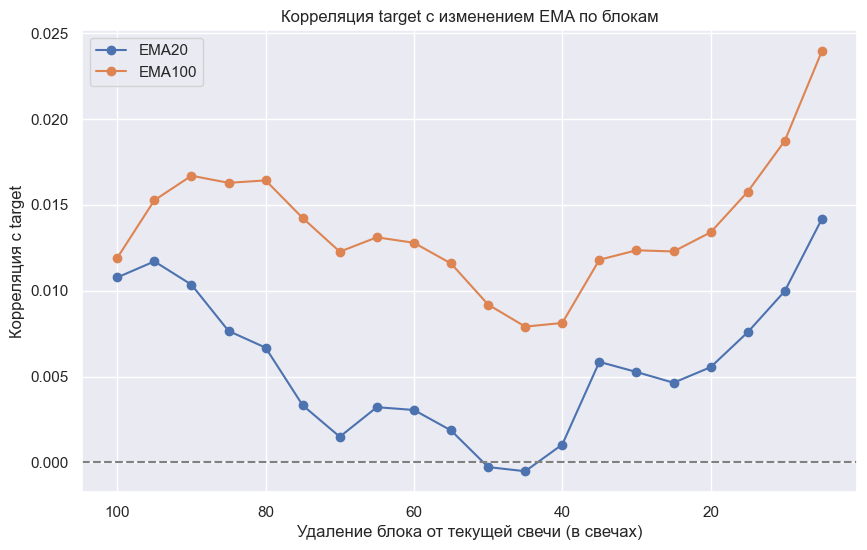

In [161]:
window_size = 100
num_blocks = 20
df = delta_ema(df, ema_lengths=[20, 100], window_size=window_size, num_blocks=num_blocks)

block_size = window_size // num_blocks
shifts = [block_size * i for i in range(1, num_blocks + 1)]  # расстояние в свечах от текущей

correlations_ema20 = []
correlations_ema100 = []

for b, shift in enumerate(shifts, 1):
    col20 = f'block{b}_ema20_rel_change'
    col100 = f'block{b}_ema100_rel_change'

    corr20 = df[[col20, 'target']].corr().iloc[0, 1]
    corr100 = df[[col100, 'target']].corr().iloc[0, 1]

    correlations_ema20.append(corr20)
    correlations_ema100.append(corr100)

plt.figure(figsize=(10, 6))
plt.plot(shifts, correlations_ema20, marker='o', label='EMA20')
plt.plot(shifts, correlations_ema100, marker='o', label='EMA100')
plt.axhline(0, color='gray', linestyle='--')
plt.gca().invert_xaxis()  # Чтобы 5 свечей (ближе) были справа
plt.xlabel('Удаление блока от текущей свечи (в свечах)')
plt.ylabel('Корреляция с target')
plt.title('Корреляция target с изменением EMA по блокам')
plt.legend()
plt.grid(True)
plt.show()

## 6.2. Корреляция целевой переменной и относительного изменения EMA в зависимости от параметров целевой переменной

In [140]:
df = df.drop('target',axis=1)
df_test = df_test.drop('target',axis=1)

In [163]:
# Параметры для перебора
target_candles_list = [5, 10, 20, 40]
target_list = [0.002, 0.005, 0.01, 0.02]
rr_threshold_list = [1.0, 1.5, 2.0, 3.0]

results = []

# Перебор параметров
for tc in target_candles_list:
    for tg in target_list:
        for rr in rr_threshold_list:
            df_tmp = add_target_column(df.copy(), target_candles=tc, target=tg, rr_threshold=rr)
            corr = df_tmp[['block1_ema50_rel_change', 'target']].corr().iloc[0, 1]
            results.append({
                'target_candles': tc,
                'target': tg,
                'rr_threshold': rr,
                'correlation': corr
            })

res_df = pd.DataFrame(results)

In [164]:
def plot_correlations(res_df):
    # Фиксируем параметры по умолчанию для каждого графика
    base_tc = res_df['target_candles'].mode()[0]
    base_tg = res_df['target'].mode()[0]
    base_rr = res_df['rr_threshold'].mode()[0]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1) Корреляция vs target_candles (фиксируем target и rr_threshold)
    df_tc = res_df[(res_df['target'] == base_tg) & (res_df['rr_threshold'] == base_rr)]
    axes[0].plot(df_tc['target_candles'], df_tc['correlation'], marker='o')
    axes[0].set_xlabel('target_candles')
    axes[0].set_ylabel('Correlation')
    axes[0].set_title(f'Correlation vs target_candles\n(target={base_tg}, rr_threshold={base_rr})')

    # 2) Корреляция vs target (фиксируем target_candles и rr_threshold)
    df_tg = res_df[(res_df['target_candles'] == base_tc) & (res_df['rr_threshold'] == base_rr)]
    axes[1].plot(df_tg['target'], df_tg['correlation'], marker='o')
    axes[1].set_xlabel('target')
    axes[1].set_ylabel('Correlation')
    axes[1].set_title(f'Correlation vs target\n(target_candles={base_tc}, rr_threshold={base_rr})')

    # 3) Корреляция vs rr_threshold (фиксируем target_candles и target)
    df_rr = res_df[(res_df['target_candles'] == base_tc) & (res_df['target'] == base_tg)]
    axes[2].plot(df_rr['rr_threshold'], df_rr['correlation'], marker='o')
    axes[2].set_xlabel('rr_threshold')
    axes[2].set_ylabel('Correlation')
    axes[2].set_title(f'Correlation vs rr_threshold\n(target_candles={base_tc}, target={base_tg})')

    plt.tight_layout()
    plt.show()

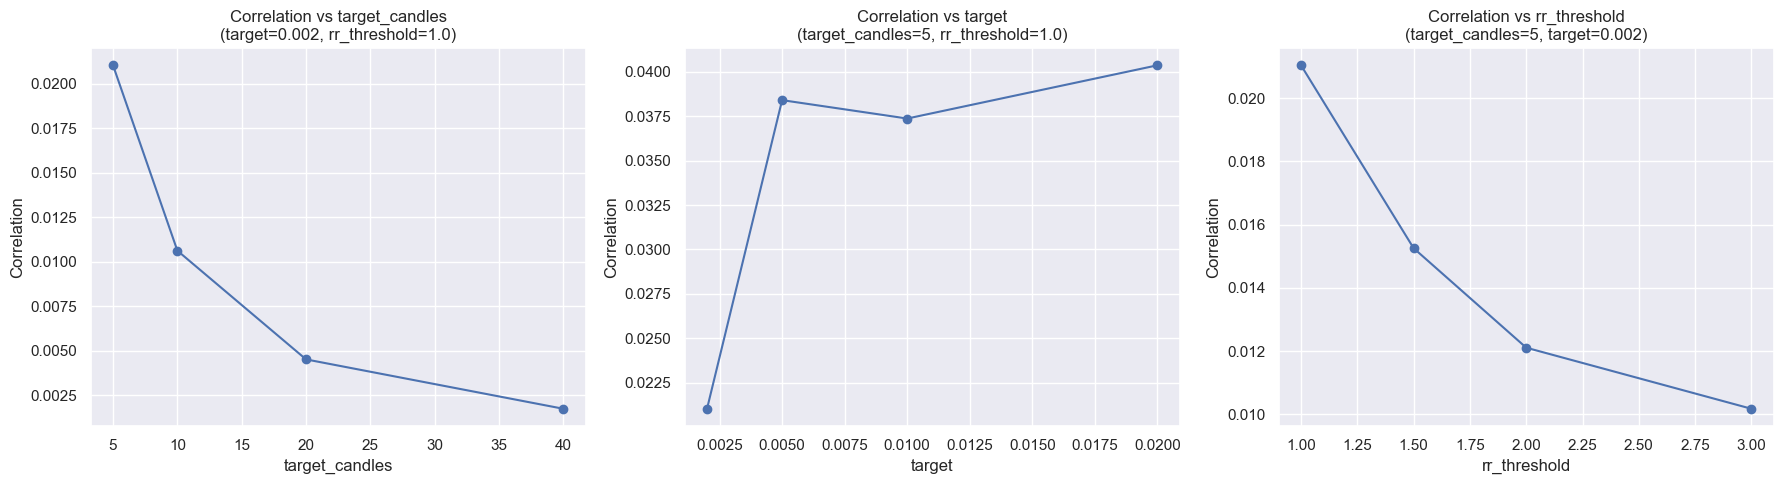

In [165]:
plot_correlations(res_df)

In [228]:
def plot_correlations_for_targets(df, param_list, window_size=100, num_blocks=20):
    block_size = window_size // num_blocks
    shifts = [block_size * i for i in range(1, num_blocks + 1)]
    
    plt.figure(figsize=(18, 5))
    
    for i, params in enumerate(param_list, 1):
        # Копируем df, добавляем таргет с нужными параметрами
        df_tmp = df.copy()
        df_tmp = add_target_column(df_tmp, 
                                  target_candles=params['target_candles'], 
                                  target=params['target'], 
                                  rr_threshold=params['rr_threshold'])
        
        # Добавляем delta_ema, если еще не добавлен (иначе можно закомментировать)
        df_tmp = delta_ema(df_tmp, ema_lengths=[20, 100], window_size=window_size, num_blocks=num_blocks)
        
        correlations_ema20 = []
        correlations_ema100 = []

        for b, shift in enumerate(shifts, 1):
            col20 = f'block{b}_ema20_rel_change'
            col100 = f'block{b}_ema100_rel_change'

            corr20 = df_tmp[[col20, 'target']].corr().iloc[0, 1]
            corr100 = df_tmp[[col100, 'target']].corr().iloc[0, 1]

            correlations_ema20.append(corr20)
            correlations_ema100.append(corr100)
        
        ax = plt.subplot(1, len(param_list), i)
        ax.plot(shifts, correlations_ema20, marker='o', label='EMA20')
        ax.plot(shifts, correlations_ema100, marker='o', label='EMA100')
        ax.axhline(0, color='gray', linestyle='--')
        ax.invert_xaxis()
        ax.set_xlabel('Удаление блока от текущей свечи (в свечах)')
        ax.set_ylabel('Корреляция с target')
        ax.set_title(f"target_candles={params['target_candles']}, target={params['target']}, rr={params['rr_threshold']}")
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()


# Пример вызова:
param_variants = [
    {'target_candles': 10, 'target': 0.01, 'rr_threshold': 2.0},
    {'target_candles': 20, 'target': 0.01, 'rr_threshold': 2.0},
    {'target_candles': 30, 'target': 0.01, 'rr_threshold': 2.0},
    
    {'target_candles': 20, 'target': 0.01, 'rr_threshold': 1.0},
    {'target_candles': 20, 'target': 0.01, 'rr_threshold': 1.0},
    {'target_candles': 20, 'target': 0.01, 'rr_threshold': 1.0}
]

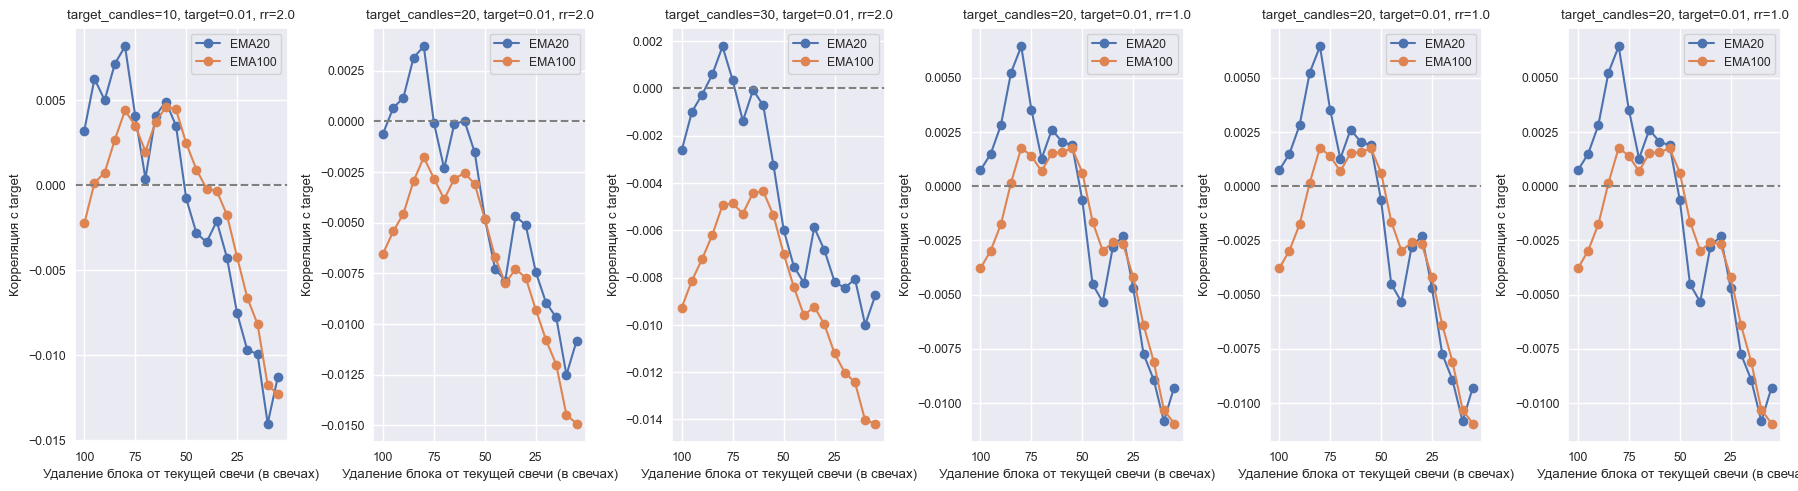

In [230]:
plot_correlations_for_targets(df, param_variants)

# ✂️ 7. Разбиение выборки

## 7.1. Разбиение выборки на train и valid

In [238]:
#Разбиваем выборку с учетом временных рядов:

X = df.drop(['target','Date','High','Low','Close','Open', 'Volume'],axis=1)
y = df['target']
separate = int(len(X) * 0.8)
X_train = X.iloc[:separate]
X_valid = X.iloc[separate:]
y_train = y.iloc[:separate]
y_valid = y.iloc[separate:]
feature_columns = X.columns.tolist()

print(f'размер датасета = {df.shape}')
print(f'размер обучающей выборки Х = {X_train.shape}, y = {y_train.shape}')
print(f'размер валидационной выборки Х = {X_valid.shape}, y = {y_valid.shape}')

размер датасета = (1448399, 27)
размер обучающей выборки Х = (1158719, 20), y = (1158719,)
размер валидационной выборки Х = (289680, 20), y = (289680,)


Разбиение тестовой выборки **X_test**, **y-test**

In [241]:
X_test = df_test.drop(['target','Date','High','Low','Close','Open', 'Volume'],axis=1)
y_test = df_test['target']


print(f'размер датасета = {X_test.shape}')

размер датасета = (305061, 20)


## 7.2. Проверка временных диапазонов

Проверка временных диапазонов. Даты обучающей и тестовой выборок не должны пересекаться.

In [81]:
print(f"Диапазон дат обучающей выборки {df['Date'].agg(['min', 'max'])}")
print(f"Диапазон дат отложенной (тестовой) выборки {df_test['Date'].agg(['min', 'max'])}")

Диапазон дат обучающей выборки min    2022-03-10 00:40:00
max    2024-12-09 21:00:00
Name: Date, dtype: object
Диапазон дат отложенной (тестовой) выборки min    2024-12-12 00:40:00
max    2025-07-11 21:00:00
Name: Date, dtype: object


# 📊 8. Распределение целевой переменной (target)

**Цель**: определение дисбаланса классов

## 8.1. Распределение целевой переменной на всем df

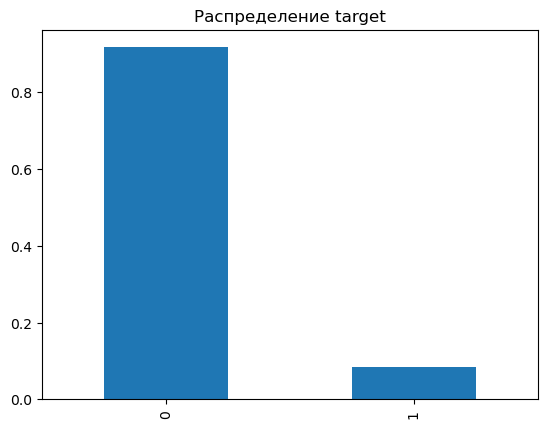

In [86]:
df['target'].value_counts(normalize=True).plot(kind='bar', title='Распределение target');

## 8.1. Распределение целевой переменной внутри выборок

Функция **show_class_balance** принимает Series с целевой переменой: **y**, **y_train**, **y_valid**, **y_test** и считает баланс классов

In [182]:
def show_class_balance(y, y_train, y_valid, y_test):
    # Собираем данные в таблицу
    balance_df = pd.DataFrame({
        'Весь датасет': y.value_counts(normalize=True).round(3),
        'Обучающая': y_train.value_counts(normalize=True).round(3),
        'Валидационная': y_valid.value_counts(normalize=True).round(3),
        'Тестовая': y_test.value_counts(normalize=True).round(3)
    }).fillna(0)  # на случай отсутствующих классов
    
    # Выводим таблицу в стиле "plain"
    print("📊 Баланс классов (доли):")
    print(
        balance_df.to_markdown(
            tablefmt="simple",  # Чистый формат без лишних линий
            stralign="center",  # Выравнивание по центру
            floatfmt=".3f"       # Формат чисел
        )
    )
    
    # Визуализация
    plt.figure(figsize=(10, 5))
    balance_df.plot(kind='bar', width=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.title('Распределение классов по выборкам', pad=20)
    plt.ylim(0, 1)
    plt.ylabel('Доля класса')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.legend(framealpha=0.9)
    plt.tight_layout()
    plt.show()

📊 Баланс классов (доли):
      Весь датасет    Обучающая    Валидационная    Тестовая
--  --------------  -----------  ---------------  ----------
 0           0.916        0.916            0.917       0.880
 1           0.084        0.084            0.083       0.120


<Figure size 1000x500 with 0 Axes>

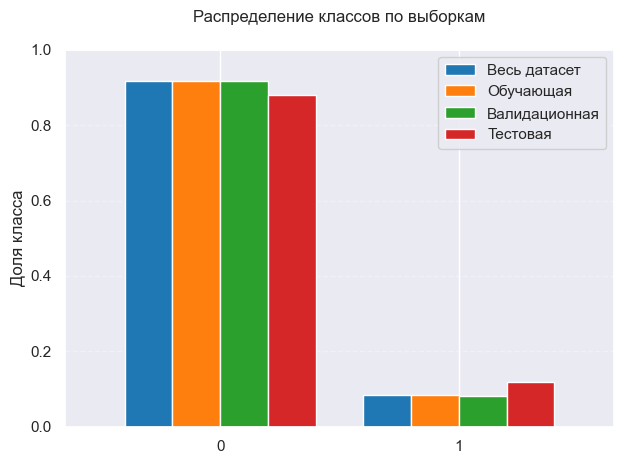

In [183]:
show_class_balance(y, y_train, y_valid, y_test)

# 📉 9. Корреляционный анализ

Функция **plot_correlation_matrix** принимает на вход df и возвращает корреляционную матрицу признаков включая целевую переменную.\
Не учитываются абсолютные значения цен графика.

In [89]:
def plot_correlation_matrix(df, drop_columns=['Data', 'High', 'Low', 'Close', 'Open', 'Volume']):
    """
    Улучшенная версия с лучшей читаемостью для большого числа признаков.
    """
    try:
        # Удаляем ненужные колонки
        data = df.drop(drop_columns, axis=1, errors='ignore')
        
        # Рассчитываем корреляционную матрицу
        corr_matrix = data.corr()
        num_features = len(corr_matrix)
        
        # Динамические настройки в зависимости от количества признаков
        if num_features <= 15:
            figsize = (10, 8)
            font_scale = 1.2
            annot = True
            label_size = 10
        elif num_features <= 30:
            figsize = (16, 14)
            font_scale = 1.0
            annot = False
            label_size = 9
        else:  # Для 50+ признаков
            figsize = (20, 18)
            font_scale = 0.8
            annot = False
            label_size = 8
            # Для очень большого числа признаков можно уменьшить плотность меток
            plt.rcParams['xtick.major.pad'] = 0.5
            plt.rcParams['ytick.major.pad'] = 0.5
        
        # Настройка стиля
        sns.set(font_scale=font_scale)
        plt.figure(figsize=figsize)
        
        # Построение тепловой карты с улучшенными настройками
        heatmap = sns.heatmap(
            corr_matrix,
            cmap='coolwarm',
            annot=annot,
            fmt=".2f",
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.7},
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool)),
            annot_kws={"size": 8} if annot else None
        )
        
        # Настройка подписей осей
        heatmap.set_xticklabels(
            heatmap.get_xticklabels(),
            rotation=45,
            ha='right',
            fontsize=label_size
        )
        heatmap.set_yticklabels(
            heatmap.get_yticklabels(),
            rotation=0,
            fontsize=label_size
        )
        
        plt.title(f'Корреляционная матрица ({num_features} признаков)', fontsize=14)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Ошибка при построении графика: {str(e)}")

# Пример использования:
# plot_correlation_matrix(df)

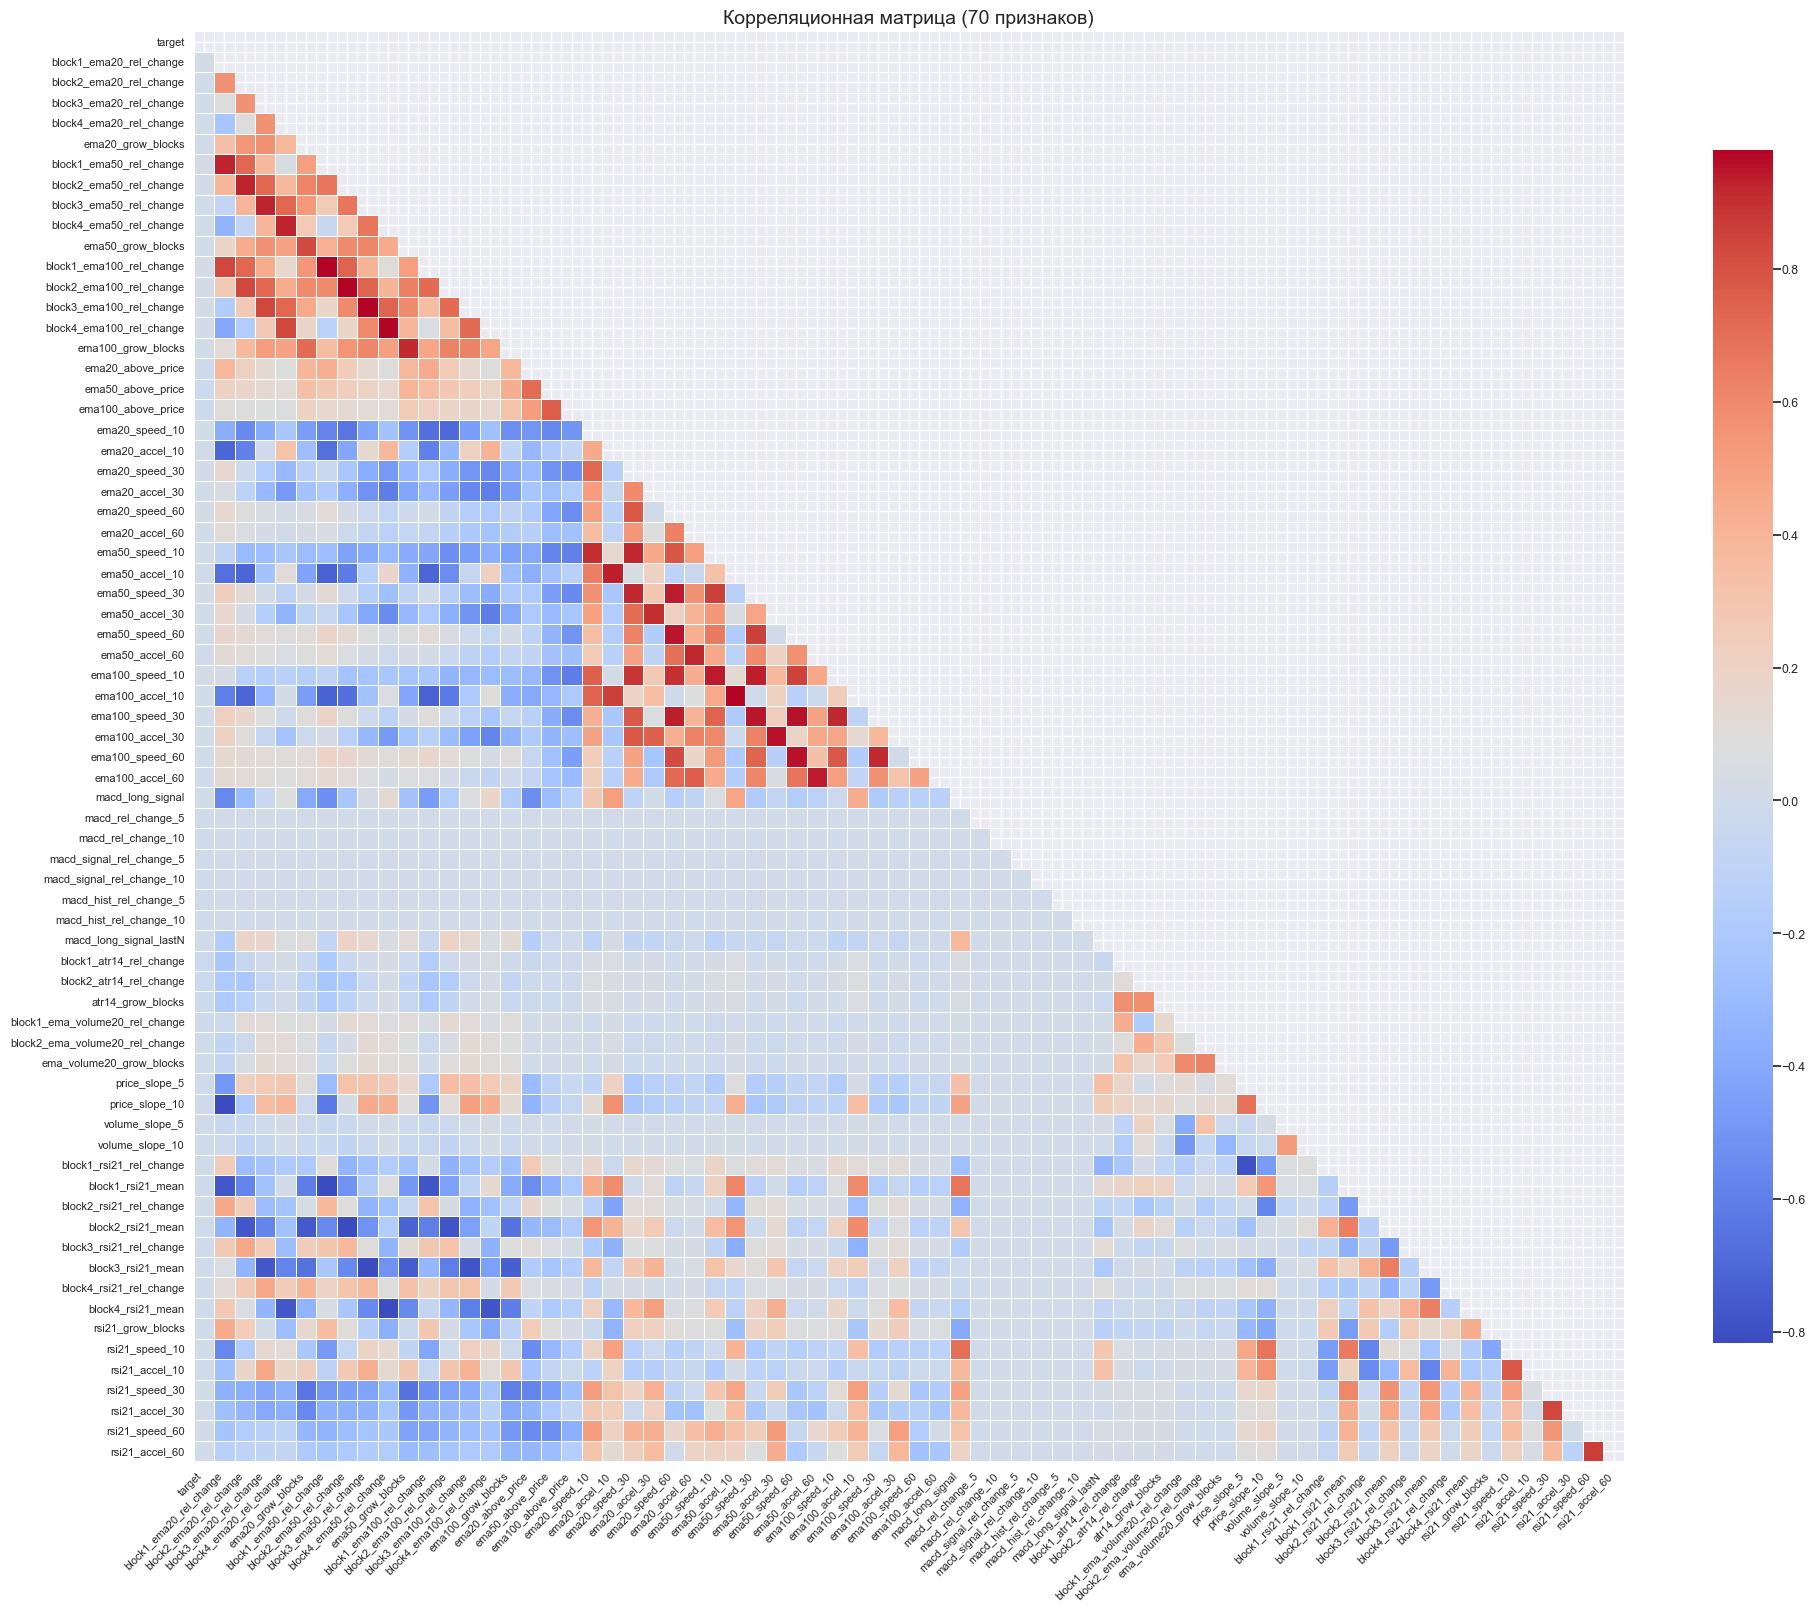

In [91]:
plot_correlation_matrix(df.drop(['Date', 'High', 'Low', 'Close', 'Open', 'Volume'],axis=1))

In [92]:
correlations = df.drop(['Date','High','Low','Close','Open', 'Volume'], axis=1).corr()[['target']].sort_values(by='target', key=lambda x: x.abs(), ascending=False)

In [93]:
correlations.head(10)

,target
target,1.000000
block1_atr14_rel_change,-0.032998
block2_atr14_rel_change,-0.026472
block1_ema100_rel_change,0.023930
ema100_above_price,-0.021535
atr14_grow_blocks,-0.020774
block2_ema100_rel_change,0.018703
block1_ema50_rel_change,0.018427
ema50_above_price,-0.017339
block3_ema100_rel_change,0.015742


# 📦 10. Feature Importance (до моделей)

**Цель**: понять, какие признаки наиболее важны\
**mutual_info_classif** вычисляет взаимную информацию между каждым признаком и целевой переменной.\
Оценивает нелинейные зависимости: Может выявить сложные связи, которые пропускает линейная корреляция

In [96]:
def explain_model_mutual_info(X_train, y_train, top_n=20, random_state=3):
    """
    Расчёт важности признаков на основе Mutual Information.
    """
    try:
        start_time = time.time()
        print(f"ℹ️ Calculating Mutual Information for {X_train.shape[1]} features...")

        # 1. Расчёт MI
        mi_scores = mutual_info_classif(X_train, y_train, random_state=random_state)
        mi_df = pd.DataFrame({
            'Feature': X_train.columns,
            'MI_Score': mi_scores
        }).sort_values('MI_Score', ascending=False)

        elapsed_time = time.time() - start_time
        print(f"✅ MI calculation completed in {elapsed_time:.2f} seconds")

        # 2. Таблица топ-N
        print(f"\n🔍 Top {top_n} Features by Mutual Information:")
        print(mi_df.head(top_n).to_markdown(index=False, floatfmt=".4f"))

        # 3. Визуализация
        plt.figure(figsize=(10, min(6, top_n * 0.3)))
        plt.barh(mi_df['Feature'].head(top_n)[::-1], 
                 mi_df['MI_Score'].head(top_n)[::-1], 
                 color='skyblue')
        plt.xlabel('Mutual Information Score')
        plt.title(f'Top {top_n} Features by Mutual Information')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Ошибка при расчёте Mutual Information: {str(e)}")

ℹ️ Calculating Mutual Information for 69 features...
✅ MI calculation completed in 1152.06 seconds

🔍 Top 10 Features by Mutual Information:
| Feature                  |   MI_Score |
|:-------------------------|-----------:|
| macd_long_signal         |     0.1282 |
| ema50_above_price        |     0.1277 |
| ema100_above_price       |     0.1277 |
| ema20_above_price        |     0.1274 |
| atr14_grow_blocks        |     0.0918 |
| ema_volume20_grow_blocks |     0.0904 |
| rsi21_grow_blocks        |     0.0811 |
| ema20_grow_blocks        |     0.0469 |
| ema50_grow_blocks        |     0.0448 |
| ema100_grow_blocks       |     0.0435 |


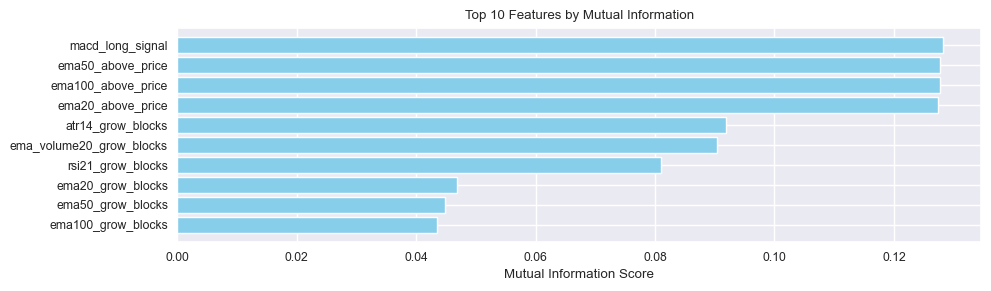

In [97]:
explain_model_mutual_info(X_train, y_train, top_n=10)

Точечный график распределения **целевой переменной**.\
Визуализация парных взаимосвязей между признаками и целевой переменной

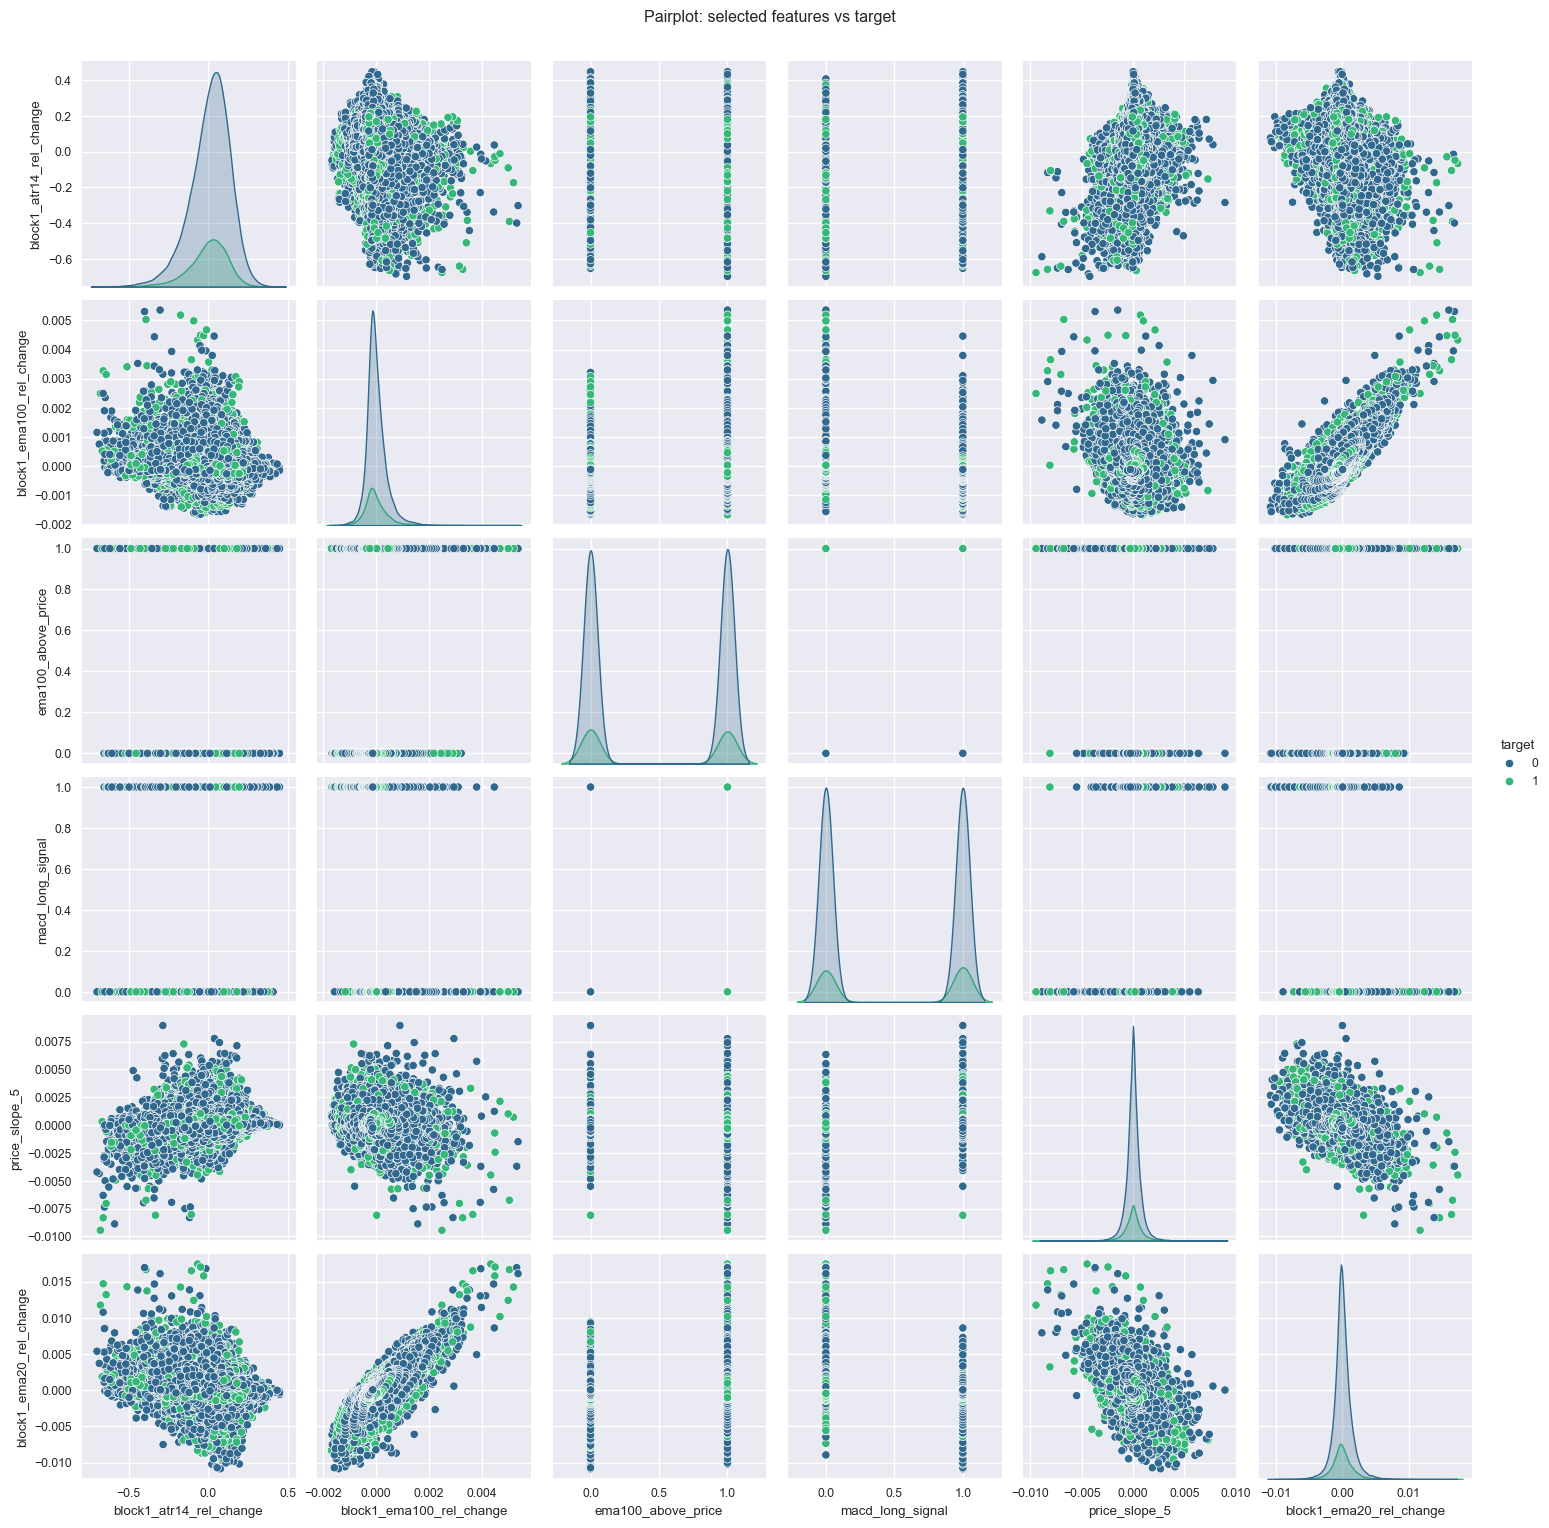

In [160]:
df_cut = df.iloc[100000:200000]

# Список признаков для визуализации
features_list = [
    'block1_atr14_rel_change',
    'block1_ema100_rel_change',
    'ema100_above_price',
    'macd_long_signal',
    'price_slope_5',
    'block1_ema20_rel_change'
]
columns_to_plot = features_list + ['target']
subset_df = df_cut[columns_to_plot].dropna()
sns.pairplot(subset_df, hue='target', diag_kind='kde', palette='viridis')
plt.suptitle('Pairplot: selected features vs target', y=1.02)
plt.show()

# 🤖 11. Обучение моделей (LogReg, RandomForest)

## 11.1. Логистическая регрессия - base line

In [104]:
start_time = time.time()

logreg = LogisticRegression(
        class_weight='balanced',
        random_state=3,
        max_iter=100,  
        n_jobs=-1,      
        solver='lbfgs'  
    )
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)

f1 = f1_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)

print(f'✅ F1 score (target): {f1:.4f}')
print(f'✅ Precision (target): {precision:.4f}')
print(f'✅ Recall (target): {recall:.4f}')
# Сохраняем модель
trained_logreg = logreg    

print("⏱ Время выполнения: {:.2f} сек".format(time.time() - start_time))

✅ F1 score (target): 0.1519
✅ Precision (target): 0.0892
✅ Recall (target): 0.5126
⏱ Время выполнения: 34.36 сек


### Предсказание LogReg модели на отложенной выборке

In [119]:
# Предсказание
y_pred = trained_logreg.predict(X_test)

# Расчет метрик
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
target_name = 'target'    
print(f'✅ F1 score ({target_name}): {f1:.4f}')
print(f'✅ Precision ({target_name}): {precision:.4f}')
print(f'✅ Recall ({target_name}): {recall:.4f}')

✅ F1 score (target): 0.2001
✅ Precision (target): 0.1251
✅ Recall (target): 0.4995


## 11.2. Случайный лес - base line

In [229]:
start_time = time.time()
target_name = 'target'

# Более оптимальные параметры
forest_base_line = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    max_depth=7,
    min_samples_leaf=1,
    min_samples_split=6,
    max_features=0.8,
    max_samples=0.8,
    random_state=3,
    n_jobs=6
)

# Обучение с кросс-валидацией (опционально)
forest = forest_base_line.fit(X_train, y_train)

# Предсказание
y_pred = forest_base_line.predict(X_valid)

# Расчет метрик
f1 = f1_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
    
print(f'✅ F1 score ({target_name}): {f1:.4f}')
print(f'✅ Precision ({target_name}): {precision:.4f}')
print(f'✅ Recall ({target_name}): {recall:.4f}')

print("⏱ Время выполнения: {:.2f} сек".format(time.time() - start_time))

✅ F1 score (target): 0.2873
✅ Precision (target): 0.1915
✅ Recall (target): 0.5755
⏱ Время выполнения: 482.79 сек


### Предсказание RandomForest на отложенной выборке

In [231]:
# Предсказание
y_pred = forest_base_line.predict(X_test)

# Расчет метрик
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
    
print(f'✅ F1 score ({target_name}): {f1:.4f}')
print(f'✅ Precision ({target_name}): {precision:.4f}')
print(f'✅ Recall ({target_name}): {recall:.4f}')

✅ F1 score (target): 0.3005
✅ Precision (target): 0.1996
✅ Recall (target): 0.6081


In [232]:
forest_base_line.feature_names_in_

array(['block1_ema20_rel_change', 'ema20_speed_10',
       'block3_ema20_rel_change', 'block4_ema20_rel_change',
       'block2_ema20_rel_change', 'price_slope_5', 'block1_rsi21_mean',
       'block1_ema50_rel_change', 'block4_ema50_rel_change',
       'ema20_speed_30', 'block2_ema50_rel_change', 'price_slope_10',
       'block3_rsi21_mean', 'block4_rsi21_mean', 'block2_rsi21_mean',
       'block3_ema50_rel_change', 'ema20_speed_60', 'ema50_speed_10',
       'ema100_speed_10', 'block1_rsi21_rel_change'], dtype=object)

# 🎯 12. Метрики: Precision, Recall, F1

Сравнение метрик **Random Forest** и **LogisticRegression**

In [127]:
y_proba_forest = forest_base_line.predict_proba(X_test)[:, 1]       # Предсказанная вероятность
y_pred_forest = (y_proba_forest >= 0.5).astype(int)             # Базовый порог = 0.5
print('Метрики для модели Random Forest')
print("Precision:", precision_score(y_test, y_pred_forest))
print("Recall:", recall_score(y_test, y_pred_forest))
print("F1 Score:", f1_score(y_test, y_pred_forest))
print()

Метрики для модели Random Forest
Precision: 0.19852272119038697
Recall: 0.6062769029586443
F1 Score: 0.2991048627725061



Построение **precision-recall** кривой для модели с наивысшим значением **f1**.\
Позволяет визуально выбрать лучший порог вероятности:

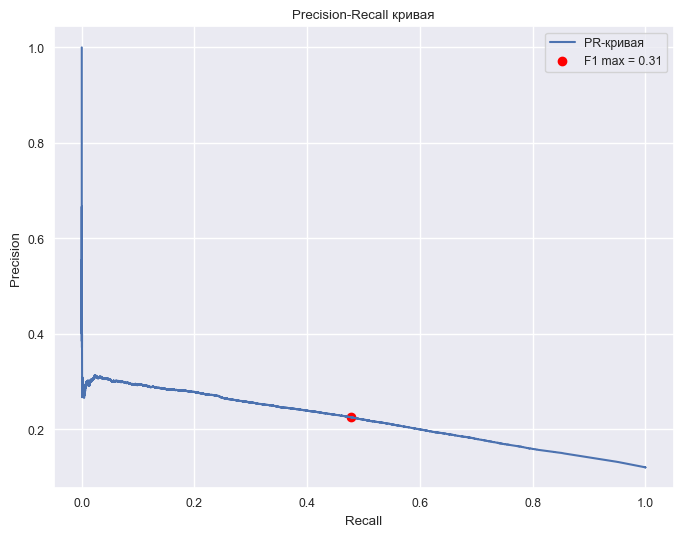

🔎 Лучший порог = 0.572, F1 = 0.306


In [129]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_forest)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)  

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# Визуализация
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="PR-кривая")
plt.scatter(recall[best_idx], precision[best_idx], color="red", label=f"F1 max = {f1_scores[best_idx]:.2f}")
plt.title("Precision-Recall кривая")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

print(f"🔎 Лучший порог = {best_threshold:.3f}, F1 = {f1_scores[best_idx]:.3f}")

# ⚖️ 13. Анализ попрога вхождения для модели

Функция **evaluate_model_with_threshold** анализирует модель бинарной классификации, подбирая оптимальный порог вероятности для предсказаний.\
Сравнивает метрики (**F1, Precision, Recall, ROC-AUC**) на тренировочной, валидационной и тестовой выборках, визуализирует зависимость метрик от порога и возвращает итоговые результаты.

In [132]:
def evaluate_model_with_threshold(model, X_train, y_train, X_valid, y_valid, X_test=None, y_test=None):
    """
    Оценивает модель и возвращает результаты в формате для сохранения
    
    Возвращает словарь в формате:
    {
        'model': model,  # обученная модель
        'metrics': {
            'train': {метрики},
            'valid': {метрики},
            'test': {метрики} (если есть),
            'optimal_threshold': float
        },
        'features': list,  # список фичей
        'timestamp': str   # время оценки
    }
    """
    from sklearn.metrics import roc_auc_score
    
    # 1. Получаем предсказанные вероятности
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_valid_proba = model.predict_proba(X_valid)[:, 1]
    
    if X_test is not None and y_test is not None:
        y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # 2. Создаем диапазон порогов
    thresholds = np.linspace(0.01, 0.99, 99)
    
    # 3. Функция для вычисления F1 при разных порогах
    def find_best_threshold(y_true, y_proba, thresholds):
        f1_scores = []
        for t in thresholds:
            y_pred = (y_proba >= t).astype(int)
            f1_scores.append(f1_score(y_true, y_pred, zero_division=0))
        best_idx = np.argmax(f1_scores)
        return thresholds[best_idx], f1_scores
    
    # 4. Находим лучшие пороги для train и valid
    train_best_threshold, train_f1_scores = find_best_threshold(y_train, y_train_proba, thresholds)
    valid_best_threshold, valid_f1_scores = find_best_threshold(y_valid, y_valid_proba, thresholds)
    
    # 5. Вычисляем средний оптимальный порог
    optimal_threshold = np.mean([train_best_threshold, valid_best_threshold])
    
    # 6. Создаем словари с метриками
    train_metrics = {
        'thresholds': thresholds,
        'f1_scores': train_f1_scores,
        'precision': [precision_score(y_train, (y_train_proba >= t).astype(int), zero_division=0) for t in thresholds],
        'recall': [recall_score(y_train, (y_train_proba >= t).astype(int), zero_division=0) for t in thresholds],
        'y_proba': y_train_proba,
        'max_f1_threshold': train_best_threshold,
        'roc_auc': roc_auc_score(y_train, y_train_proba)  # Добавлено ROC AUC
    }
    
    valid_metrics = {
        'thresholds': thresholds,
        'f1_scores': valid_f1_scores,
        'precision': [precision_score(y_valid, (y_valid_proba >= t).astype(int), zero_division=0) for t in thresholds],
        'recall': [recall_score(y_valid, (y_valid_proba >= t).astype(int), zero_division=0) for t in thresholds],
        'y_proba': y_valid_proba,
        'max_f1_threshold': valid_best_threshold,
        'roc_auc': roc_auc_score(y_valid, y_valid_proba)  # Добавлено ROC AUC
    }
    
    # 7. Выводим результаты
    print(f"🎯 Лучший порог по F1 (Train): {train_best_threshold:.4f}")
    print(f"🎯 Лучший порог по F1 (Valid): {valid_best_threshold:.4f}")
    print(f"✅ Усредненный оптимальный порог: {optimal_threshold:.4f}")
    print(f"\n📊 ROC AUC Scores:")
    print(f"✅ Train ROC AUC: {train_metrics['roc_auc']:.4f}")
    print(f"✅ Valid ROC AUC: {valid_metrics['roc_auc']:.4f}")
    
    # 8. Считаем финальные метрики с усредненным порогом
    def calculate_final_metrics(y_true, y_proba, threshold, set_name):
        y_pred = (y_proba >= threshold).astype(int)
        metrics = {
            'F1': f1_score(y_true, y_pred, zero_division=0),
            'Precision': precision_score(y_true, y_pred, zero_division=0),
            'Recall': recall_score(y_true, y_pred, zero_division=0),
            'ROC_AUC': roc_auc_score(y_true, y_proba)  # Добавлено ROC AUC
        }
        print(f"\n📊 {set_name} set (Threshold = {threshold:.4f}):")
        print(f"✅ F1: {metrics['F1']:.4f}")
        print(f"✅ Precision: {metrics['Precision']:.4f}")
        print(f"✅ Recall: {metrics['Recall']:.4f}")
        print(f"✅ ROC AUC: {metrics['ROC_AUC']:.4f}")
        return metrics
    
    train_metrics['final_metrics'] = calculate_final_metrics(y_train, y_train_proba, optimal_threshold, "Train")
    valid_metrics['final_metrics'] = calculate_final_metrics(y_valid, y_valid_proba, optimal_threshold, "Valid")
    
    results = {
        'train': train_metrics,
        'valid': valid_metrics,
        'optimal_threshold': optimal_threshold
    }
    
    if X_test is not None and y_test is not None:
        test_metrics = {
            'thresholds': thresholds,
            'f1_scores': [f1_score(y_test, (y_test_proba >= t).astype(int), zero_division=0) for t in thresholds],
            'precision': [precision_score(y_test, (y_test_proba >= t).astype(int), zero_division=0) for t in thresholds],
            'recall': [recall_score(y_test, (y_test_proba >= t).astype(int), zero_division=0) for t in thresholds],
            'y_proba': y_test_proba,
            'roc_auc': roc_auc_score(y_test, y_test_proba)  # Добавлено ROC AUC
        }
        test_metrics['final_metrics'] = calculate_final_metrics(
            y_test, y_test_proba, optimal_threshold, "Test"
        )
        results['test'] = test_metrics
    
    # 9. Визуализация (остается без изменений)
    plt.figure(figsize=(18, 6))
    
    # 1. Кривые для обучающей выборки
    plt.subplot(1, 3, 1)
    plt.plot(train_metrics['thresholds'], train_metrics['precision'], label='Precision', color='blue')
    plt.plot(train_metrics['thresholds'], train_metrics['recall'], label='Recall', color='green')
    plt.plot(train_metrics['thresholds'], train_metrics['f1_scores'], label='F1', color='red')
    plt.axvline(optimal_threshold, color='k', linestyle='-', label=f'Avg Optimal: {optimal_threshold:.3f}')
    plt.axvline(train_best_threshold, color='b', linestyle=':', label=f'Train Max F1: {train_best_threshold:.3f}')
    plt.title('Train Selection')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    
    # 2. Кривые для валидационной выборки
    plt.subplot(1, 3, 2)
    plt.plot(valid_metrics['thresholds'], valid_metrics['precision'], label='Precision', color='blue')
    plt.plot(valid_metrics['thresholds'], valid_metrics['recall'], label='Recall', color='green')
    plt.plot(valid_metrics['thresholds'], valid_metrics['f1_scores'], label='F1', color='red')
    plt.axvline(optimal_threshold, color='k', linestyle='-', label=f'Avg Optimal: {optimal_threshold:.3f}')
    plt.axvline(valid_best_threshold, color='orange', linestyle=':', label=f'Valid Max F1: {valid_best_threshold:.3f}')
    plt.title('Test Set')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    
    # 3. Сравнение F1-кривых с новым порогом
    plt.subplot(1, 3, 3)
    plt.plot(train_metrics['thresholds'], train_metrics['f1_scores'], label='Train F1', color='blue')
    plt.plot(valid_metrics['thresholds'], valid_metrics['f1_scores'], label='Valid F1', color='orange')
    
    # Добавлена третья линия для тестовой выборки, если она есть
    if X_test is not None and y_test is not None:
        plt.plot(test_metrics['thresholds'], test_metrics['f1_scores'], label='Test F1', color='green')
    
    plt.axvline(optimal_threshold, color='k', linestyle='-', label=f'Avg Optimal: {optimal_threshold:.3f}')
    plt.axvline(train_best_threshold, color='b', linestyle=':', alpha=0.5)
    plt.axvline(valid_best_threshold, color='orange', linestyle=':', alpha=0.5)
    plt.title('F1 Comparison with Optimal Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    
    # 10. Выводим итоговые метрики в таблице (добавляем ROC AUC)
    final_table = [
        ["Dataset", "Threshold Type"] + list(train_metrics['final_metrics'].keys()),
        ["Train", f"Average Optimal ({optimal_threshold:.4f})"] + list(train_metrics['final_metrics'].values()),
        ["Test", f"Average Optimal ({optimal_threshold:.4f})"] + list(valid_metrics['final_metrics'].values())
    ]
    
    if X_test is not None and y_test is not None:
        final_table.append(
            ["Test", f"Average Optimal ({optimal_threshold:.4f})"] + list(results['test']['final_metrics'].values())
        )
    
    # print("\nИтоговые метрики со средним оптимальным порогом:")
    # print(tabulate(final_table, headers="firstrow", floatfmt=".4f", tablefmt="grid"))

     # Формируем итоговый словарь в нужном формате
    model_package = {
        'model': model,
        'metrics': {
            'train': train_metrics['final_metrics'],
            'valid': valid_metrics['final_metrics'],
            'optimal_threshold': optimal_threshold
        },
        'features': list(X_train.columns),
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
    
    if X_test is not None and y_test is not None:
        model_package['metrics']['test'] = results['test']['final_metrics']
    
    return model_package

🎯 Лучший порог по F1 (Train): 0.5900
🎯 Лучший порог по F1 (Valid): 0.5500
✅ Усредненный оптимальный порог: 0.5700

📊 ROC AUC Scores:
✅ Train ROC AUC: 0.7204
✅ Valid ROC AUC: 0.7348

📊 Train set (Threshold = 0.5700):
✅ F1: 0.2869
✅ Precision: 0.2124
✅ Recall: 0.4419
✅ ROC AUC: 0.7204

📊 Valid set (Threshold = 0.5700):
✅ F1: 0.2966
✅ Precision: 0.2205
✅ Recall: 0.4527
✅ ROC AUC: 0.7348

📊 Test set (Threshold = 0.5700):
✅ F1: 0.3062
✅ Precision: 0.2246
✅ Recall: 0.4806
✅ ROC AUC: 0.6792


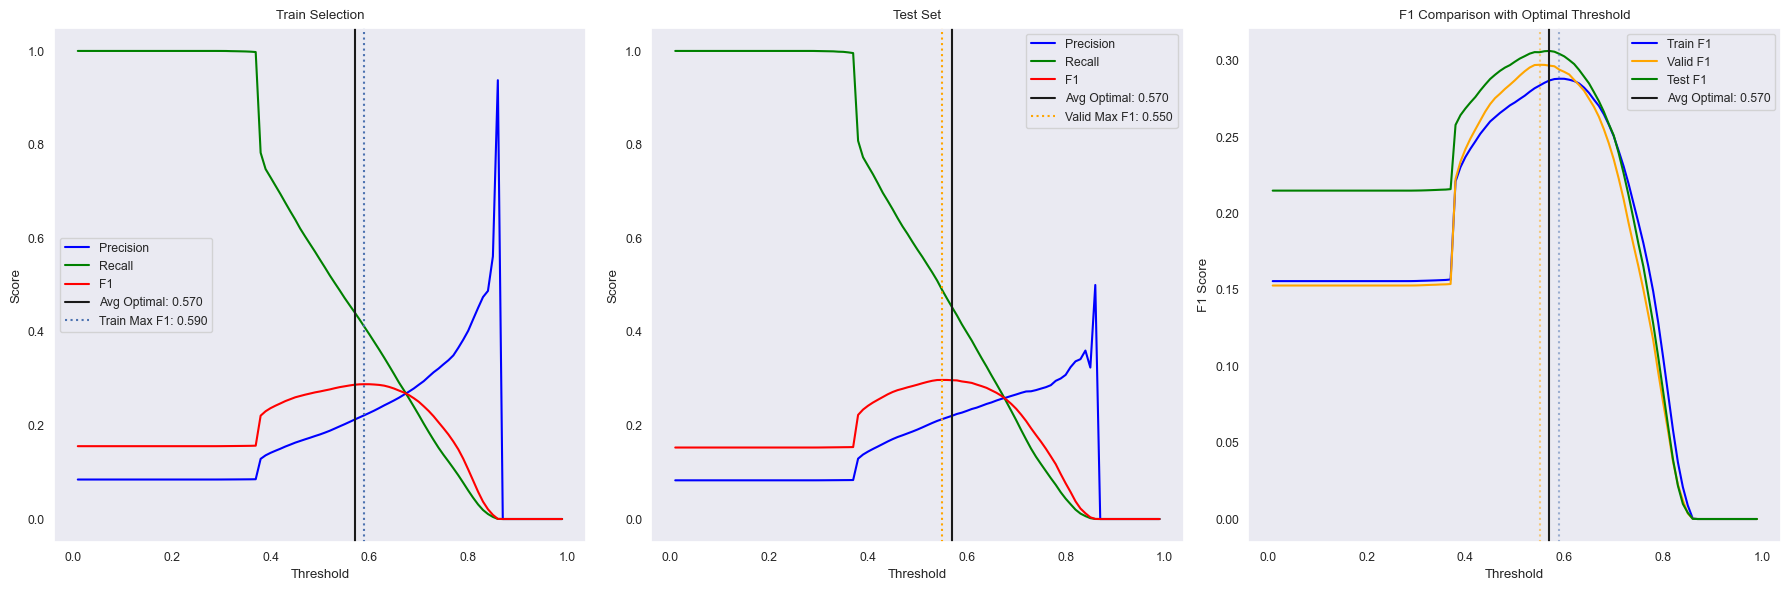

In [133]:
forest_base_line_package = evaluate_model_with_threshold(forest, X_train, y_train, X_valid, y_valid, X_test, y_test)

# 🧠 14. Интерпретация влияния признаков на модель 

## 14.1. SHAP (SHapley Additive exPlanations)

**SHAP** - это метод объяснения предсказаний модели, основанный на теории игр (значения Шепли).\
Он показывает вклад каждого признака в конкретное предсказание, учитывая все возможные комбинации признаков.

In [137]:
def explain_model_shap(X_train, model, sample_size=2000, top_n=20, n_jobs = -1):
    """
    Оборачивает расчет SHAP-важности и визуализации признаков
    
    Параметры:
    ----------
    X_train : pd.DataFrame
        Датафрейм признаков
    model : sklearn/xgboost модель
        Обученная модель (RandomForest, LogisticRegression, XGB и др.)
    sample_size : int
        Размер случайной подвыборки
    top_n : int
        Кол-во признаков для отображения
    """
    try:
        total_start_time = time.time()
        model_type = type(model).__name__
        
        print(f"ℹ️ Model type: {model_type}")
        print(f"ℹ️ Number of classes: {getattr(model, 'n_classes_', 'unknown')}")
        
        # 1. Инициализация Explainer
        print("🔄 Initializing SHAP explainer...")
        explainer_start = time.time()
        if model_type in ['RandomForestClassifier', 'RandomForestRegressor', 
                          'XGBClassifier', 'XGBRegressor', 
                          'LGBMClassifier', 'LGBMRegressor']:
            explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
        elif model_type in ['LogisticRegression', 'LinearRegression']:
            explainer = shap.LinearExplainer(model, X_train)
        else:
            explainer = shap.Explainer(model, X_train)
        explainer_time = time.time() - explainer_start
        print(f"✅ SHAP explainer initialized in {timedelta(seconds=explainer_time)}")
        
        # 2. Подвыборка
        sample_size = min(sample_size, len(X_train))
        sample_idx = np.random.choice(X_train.index, size=sample_size, replace=False)
        X_sample = X_train.loc[sample_idx]

        print(f"\n🔄 Calculating SHAP values for {sample_size} samples...")
        shap_start = time.time()

        # Параллельная обработка
        n_jobs = n_jobs
        n_chunks = 4 * (os.cpu_count() or 1)

        def calc_chunk(chunk):
            return explainer.shap_values(chunk, approximate=True, check_additivity=False)

        chunks = np.array_split(X_sample, n_chunks)
        results = Parallel(n_jobs=n_jobs)(delayed(calc_chunk)(chunk) for chunk in chunks)

        # Объединение результатов
        if isinstance(results[0], list):
            shap_values = [np.concatenate([r[i] for r in results]) for i in range(len(results[0]))]
        else:
            shap_values = np.concatenate(results)

        shap_time = time.time() - shap_start
        print(f"✅ SHAP values calculated in {timedelta(seconds=shap_time)}")
        print(f"⏱ Average time per sample: {shap_time/sample_size:.4f} seconds")

        # 3. Обработка SHAP
        if isinstance(shap_values, list):
            shap_values = shap_values[1] if len(shap_values) == 2 else np.mean(shap_values, axis=0)
        elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
            shap_values = shap_values[:, :, 1]

        print(f"ℹ️ Processed SHAP values shape: {shap_values.shape}")

        # 4. Анализ важности
        print("\n🔄 Calculating feature importance...")
        analysis_start = time.time()
        importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'SHAP_Importance': np.abs(shap_values).mean(axis=0),
            'Direction': np.where(np.mean(shap_values, axis=0) > 0, 'Positive', 'Negative')
        })
        if hasattr(model, 'feature_importances_'):
            importance_df['Model_Importance'] = model.feature_importances_
            importance_df['Model_%'] = 100 * importance_df['Model_Importance'] / importance_df['Model_Importance'].max()

        importance_df['SHAP_%'] = 100 * importance_df['SHAP_Importance'] / importance_df['SHAP_Importance'].max()
        importance_df = importance_df.sort_values('SHAP_%', ascending=False)
        importance_df['Rank'] = range(1, len(importance_df) + 1)
        importance_df['Cumulative_SHAP_%'] = importance_df['SHAP_%'].cumsum()
        analysis_time = time.time() - analysis_start
        print(f"✅ Feature analysis completed in {timedelta(seconds=analysis_time)}")

        # 5. Таблица
        print("\n🔍 Top Features by SHAP Importance:")
        display_cols = ['Rank', 'Feature', 'SHAP_%', 'Direction']
        if 'Model_%' in importance_df.columns:
            display_cols.append('Model_%')
        print(importance_df.head(top_n)[display_cols].to_markdown(index=False, floatfmt=".1f"))

        print("\n📊 Key Metrics:")
        print(f"• Top-5 features explain: {importance_df['Cumulative_SHAP_%'].iloc[4]:.1f}%")
        pos_count = (importance_df['Direction'] == 'Positive').sum()
        neg_count = (importance_df['Direction'] == 'Negative').sum()
        print(f"• Positive/Negative: {pos_count}/{neg_count}")

        # 6. Простая визуализация
        plt.figure(figsize=(10, min(6, top_n * 0.3)))
        colors = importance_df['Direction'].head(top_n).map({'Positive': 'tomato', 'Negative': 'dodgerblue'})
        plt.barh(importance_df['Feature'].head(top_n)[::-1], 
                 importance_df['SHAP_%'].head(top_n)[::-1],
                 color=colors[::-1])
        plt.title(f'Top {top_n} Features by SHAP')
        plt.xlabel('Relative SHAP Importance (%)')
        plt.tight_layout()
        plt.show()

        # 7. Общее время
        total_time = time.time() - total_start_time
        print(f"\n⏱ Total execution time: {timedelta(seconds=total_time)}")
        print("="*50)
        print("Time breakdown:")
        print(f"- Explainer init: {timedelta(seconds=explainer_time)}")
        print(f"- SHAP values: {timedelta(seconds=shap_time)} ({shap_time/total_time*100:.1f}%)")
        print(f"- Analysis: {timedelta(seconds=analysis_time)} ({analysis_time/total_time*100:.1f}%)")

        return importance_df

    except Exception as e:
        print(f"\n❌ Error: {str(e)}")
        if 'shap_values' in locals():
            print(f"SHAP values type: {type(shap_values)}")
            if hasattr(shap_values, 'shape'):
                print(f"SHAP values shape: {shap_values.shape}")
        print(f"X_train shape: {X_train.shape if X_train is not None else 'N/A'}")
        if hasattr(model, 'n_features_in_'):
            print(f"Model features: {model.n_features_in_}")
        return None

ℹ️ Model type: RandomForestClassifier
ℹ️ Number of classes: 2
🔄 Initializing SHAP explainer...
✅ SHAP explainer initialized in 0:00:00.028270

🔄 Calculating SHAP values for 10000 samples...
✅ SHAP values calculated in 0:00:10.656402
⏱ Average time per sample: 0.0011 seconds
ℹ️ Processed SHAP values shape: (10000, 69)

🔄 Calculating feature importance...
✅ Feature analysis completed in 0:00:00.113908

🔍 Top Features by SHAP Importance:
|   Rank | Feature                  |   SHAP_% | Direction   |   Model_% |
|-------:|:-------------------------|---------:|:------------|----------:|
|      1 | block1_ema20_rel_change  |    100.0 | Negative    |     100.0 |
|      2 | block3_ema20_rel_change  |     41.9 | Negative    |      36.2 |
|      3 | ema20_speed_10           |     39.7 | Negative    |      61.5 |
|      4 | block2_ema20_rel_change  |     37.7 | Negative    |      36.2 |
|      5 | block4_ema20_rel_change  |     36.2 | Negative    |      26.4 |
|      6 | price_slope_5            

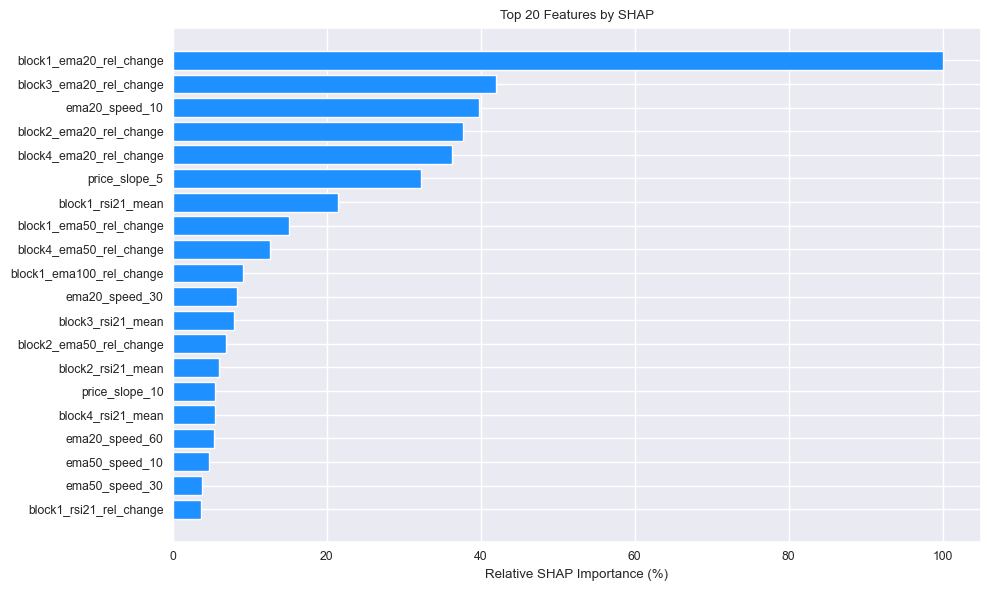


⏱ Total execution time: 0:00:11.745727
Time breakdown:
- Explainer init: 0:00:00.028270
- SHAP values: 0:00:10.656402 (90.7%)
- Analysis: 0:00:00.113908 (1.0%)


In [138]:
# Пример использования:
explain_model_shap(X_train, forest_base_line, sample_size=10000, top_n=20);

## 14.2. Permutation Importance (Перестановочная важность)

**Permutation Importance** – это метод оценки важности признаков, основанный на ухудшении качества модели при случайном перемешивании значений признака.\
Если после перемешивания метрика модели значительно падает, признак считается важным.

In [141]:
def explain_model_permutation(X, y, model, scoring='f1', n_repeats=5, top_n=20, random_state=3):
    """
    Оценивает важность признаков с помощью Permutation Importance.
    
    Параметры:
    ----------
    X : pd.DataFrame
        Признаки (X_train или X_valid)
    y : pd.Series
        Целевая переменная
    model : обученная модель
        RandomForest, LogisticRegression, XGBoost и т.д.
    scoring : str
        Метрика (например, 'f1', 'accuracy', 'roc_auc')
    n_repeats : int
        Количество повторов для случайности
    top_n : int
        Кол-во признаков для отображения
    random_state : int
        Случайное зерно для воспроизводимости
    
    Возвращает:
    -----------
    pd.DataFrame — таблица важности признаков
    """
    try:
        print(f"ℹ️ Model type: {type(model).__name__}")
        print(f"ℹ️ Scoring metric: {scoring}")

        start_time = time.time()

        # Оптимальное количество потоков
        n_jobs = os.cpu_count() - 1 if os.cpu_count() else 1

        print("🔄 Calculating permutation importance...")
        result = permutation_importance(
            model, X, y,
            scoring=scoring,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=n_jobs
        )

        elapsed = time.time() - start_time
        print(f"✅ Completed in {timedelta(seconds=elapsed)}")

        # Формируем датафрейм
        importances_df = pd.DataFrame({
            'Feature': X.columns,
            'Mean Importance': result.importances_mean,
            'Std': result.importances_std
        })
        importances_df['Significant'] = importances_df['Mean Importance'] - 2 * importances_df['Std'] > 0
        importances_df = importances_df.sort_values(by='Mean Importance', ascending=False).reset_index(drop=True)
        importances_df['Rank'] = importances_df.index + 1

        print("\n🔍 Top Features by Permutation Importance:")
        display_cols = ['Rank', 'Feature', 'Mean Importance', 'Std', 'Significant']
        print(importances_df.head(top_n)[display_cols].to_markdown(index=False, floatfmt=".3f"))

        # Простая визуализация
        top_features = importances_df.head(top_n)
        plt.figure(figsize=(10, min(6, top_n * 0.3)))
        bars = plt.barh(top_features['Feature'][::-1], top_features['Mean Importance'][::-1],
                        xerr=top_features['Std'][::-1], color='mediumseagreen')
        plt.xlabel("Mean Importance")
        plt.title(f"Top {top_n} Features by Permutation Importance")
        plt.tight_layout()
        plt.show()

        return importances_df

    except Exception as e:
        print(f"❌ Error during permutation importance: {e}")
        return None

ℹ️ Model type: RandomForestClassifier
ℹ️ Scoring metric: f1
🔄 Calculating permutation importance...
✅ Completed in 0:14:48.341868

🔍 Top Features by Permutation Importance:
|   Rank | Feature                        |   Mean Importance |   Std | Significant   |
|-------:|:-------------------------------|------------------:|------:|:--------------|
|      1 | block1_ema20_rel_change        |             0.043 | 0.000 | True          |
|      2 | block3_ema20_rel_change        |             0.022 | 0.000 | True          |
|      3 | block4_ema20_rel_change        |             0.020 | 0.000 | True          |
|      4 | block2_ema20_rel_change        |             0.018 | 0.000 | True          |
|      5 | price_slope_5                  |             0.016 | 0.000 | True          |
|      6 | block1_rsi21_mean              |             0.016 | 0.000 | True          |
|      7 | ema20_speed_10                 |             0.012 | 0.000 | True          |
|      8 | block3_rsi21_mean       

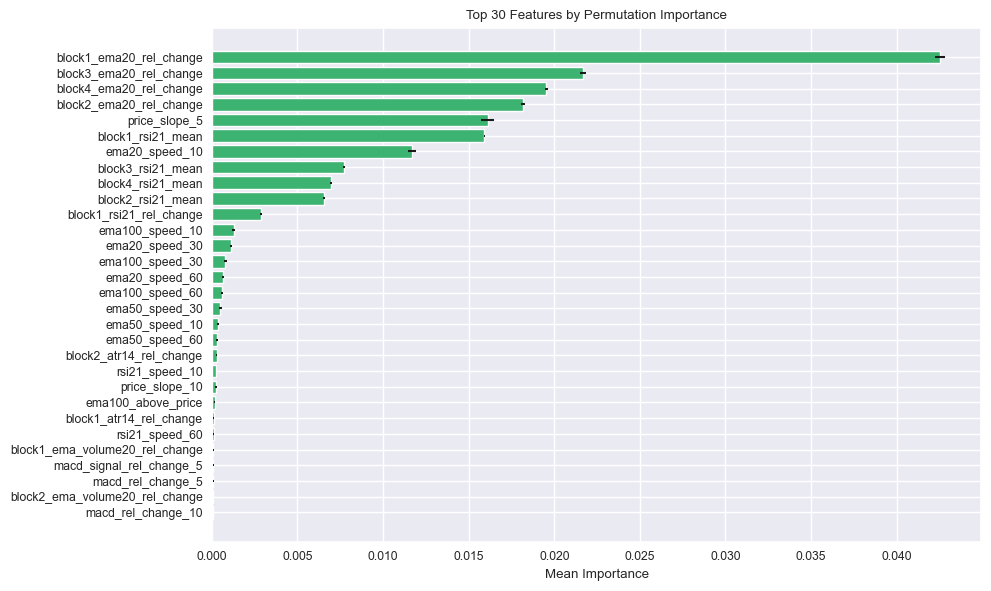

In [142]:
permutation_result = explain_model_permutation(X_train, y_train, forest, scoring='f1', top_n=30);

# 📋 15. Выбор оптимальных признаков на основании полученных данных

In [212]:
base_features = ['block1_ema20_rel_change', 
                 'ema20_speed_10',
                'block3_ema20_rel_change',
                'block4_ema20_rel_change',
                'block2_ema20_rel_change',
                 'price_slope_5',
                 'block1_rsi21_mean',
                 'block1_ema50_rel_change',
                 'block4_ema50_rel_change',
                 'ema20_speed_30',
                 'block2_ema50_rel_change',
                 'price_slope_10',
                 'block3_rsi21_mean',
                 'block4_rsi21_mean',
                 'block2_rsi21_mean',
                 'block3_ema50_rel_change',
                 'ema20_speed_60',
                 'ema50_speed_10',
                 'ema100_speed_10',
                 'block1_rsi21_rel_change',
                'Date', 'High', 'Low', 'Close', 'Open', 'Volume','target']

In [214]:
df = df[base_features]
df_test = df_test[base_features]
df.head(3)

,block1_ema20_rel_change,ema20_speed_10,block3_ema20_rel_change,block4_ema20_rel_change,block2_ema20_rel_change,price_slope_5,block1_rsi21_mean,block1_ema50_rel_change,block4_ema50_rel_change,ema20_speed_30,block2_ema50_rel_change,price_slope_10,block3_rsi21_mean,block4_rsi21_mean,block2_rsi21_mean,block3_ema50_rel_change,ema20_speed_60,ema50_speed_10,ema100_speed_10,block1_rsi21_rel_change,Date,High,Low,Close,Open,Volume,target
219,0.001151,-0.000290,0.001160,0.000122,0.002314,0.000213,40.019915,0.000834,-0.000006,0.000018,0.001140,-0.000334,43.354887,49.930226,36.200881,0.000506,0.000068,-0.000086,0.000008,-0.106163,2022-03-10 00:40:00,13.984,13.981,13.984,13.982,28.3,0
220,0.000803,-0.000261,0.001260,0.000394,0.002291,0.000496,41.663476,0.000704,0.000111,0.000015,0.001176,0.000042,42.559758,48.354916,35.996811,0.000573,0.000069,-0.000083,0.000008,-0.170419,2022-03-10 00:41:00,14.020,13.984,14.020,13.984,97.1,0
221,0.000442,-0.000221,0.001344,0.000797,0.002128,0.000595,43.531934,0.000559,0.000288,0.000009,0.001153,0.000241,41.894926,46.036496,36.409418,0.000634,0.000067,-0.000073,0.000011,-0.191528,2022-03-10 00:42:00,14.025,14.016,14.016,14.020,249.4,0


# 16. Участки где модель дает сигнал

In [243]:
# Преобразуем строку с датой в datetime, если еще не сделано
df_test['Date'] = pd.to_datetime(df_test['Date'])

# Укажем нужный временной интервал
start_date = '2025-07-07 10:00:00'
end_date = '2025-07-09 22:00:00'

# Фильтруем по диапазону дат
df_last_2000 = df_test[(df_test['Date'] >= start_date) & (df_test['Date'] <= end_date)].copy()

# Выделим X_test — только фичи, которые использует модель
features_columns = forest_base_line.feature_names_in_
X_test_last_2000 = df_last_2000[features_columns]

# Получаем вероятности класса 1
probabilities = forest_base_line.predict_proba(X_test_last_2000)
df_last_2000['Probability_1'] = probabilities[:, 1]

In [247]:
# Функция для обновления графика при изменении порога
def update_plot(threshold):
    # Создаем сигналы на основе порога
    df_last_2000['Signal'] = (df_last_2000['Probability_1'] >= threshold).astype(int)
    
    # Создаем новый график
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                       vertical_spacing=0.02,
                       row_heights=[0.7, 0.3])

    # Свечной график
    fig.add_trace(go.Candlestick(
        x=df_last_2000['Date'],
        open=df_last_2000['Open'],
        high=df_last_2000['High'],
        low=df_last_2000['Low'],
        close=df_last_2000['Close'],
        name='Цены'
    ), row=1, col=1)

    # Сигналы модели (где вероятность >= порогу)
    signals = df_last_2000[df_last_2000['Signal'] == 1]
    fig.add_trace(go.Scatter(
        x=signals['Date'],
        y=signals['Low'] * 0.99,  # маркеры чуть ниже минимумов
        mode='markers',
        marker=dict(color='green', size=10, symbol='triangle-up'),
        name=f'Сигнал BUY (≥{threshold:.2f})'
    ), row=1, col=1)

    # Объемы торгов
    fig.add_trace(go.Bar(
        x=df_last_2000['Date'],
        y=df_last_2000['Volume'],
        name='Объем'
    ), row=2, col=1)

    # Настройки графика
    fig.update_layout(
        title=f'Тестовые предсказания модели (Порог: {threshold:.2f})',
        xaxis_rangeslider_visible=False,
        hovermode='x unified',
        height=700
    )

    # Добавляем кнопки для навигации по времени
    fig.update_xaxes(
        rangebreaks=[{'bounds': ['sat', 'mon']}],  # скрываем выходные
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1д", step="day", stepmode="backward"),
                dict(count=7, label="1н", step="day", stepmode="backward"),
                dict(count=1, label="1м", step="month", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    
    fig.show()


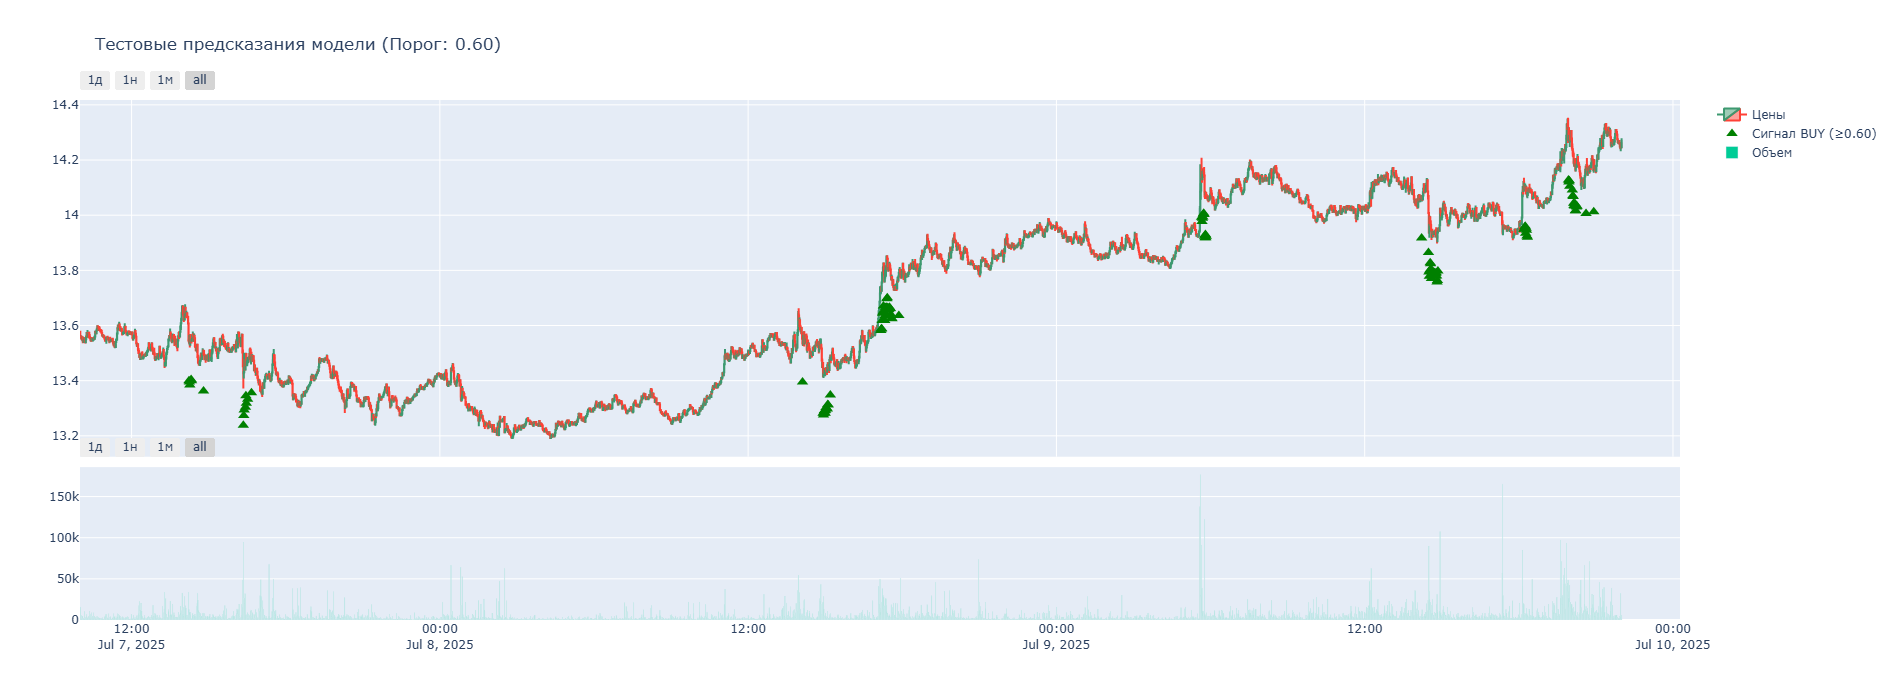

interactive(children=(FloatSlider(value=0.6, continuous_update=False, description='Порог:', max=1.0, step=0.01…

<function __main__.update_plot(threshold)>

In [249]:
# Создаем слайдер с начальным значением 0.7
threshold_slider = widgets.FloatSlider(
    value=0.6,  # начальное значение 0.7
    min=0.0,
    max=1.0,
    step=0.01,
    description='Порог:',
    continuous_update=False
)

# Используем interact вместо interactive
widgets.interact(update_plot, threshold=threshold_slider)

# 17. Бэктест торговой модели

In [252]:
def backtest_model_2(df, model, threshold=0.5, tp_pct=0.04, rr=2.0, plot=True):
    """
    Пошаговый бэктест торговой модели с TP и SL.
    После закрытия сделки следующая проверка начинается со следующей свечи.
    Результат: метрики, таблица сделок, помесячная статистика и кривая капитала.
    """

    # Базовые колонки
    base_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    if 'target' in df.columns:
        base_cols.append('target')

    # Признаки
    feature_cols = [c for c in df.columns if c not in base_cols]

    # Для SL
    sl_pct = tp_pct / rr

    # Предсказания
    preds = model.predict_proba(df[feature_cols])[:, 1]
    df = df.copy()
    df['pred'] = preds

    all_trades = []
    current_trade = None
    i = 0
    n = len(df)
    balance = [0]  # кривая капитала

    while i < n:
        row = df.iloc[i]

        # Если нет сделки — ищем вход
        if current_trade is None:
            if row['pred'] >= threshold:
                entry_price = row['Close']
                tp_price = entry_price * (1 + tp_pct)
                sl_price = entry_price * (1 - sl_pct)

                current_trade = {
                    'entry_date': row['Date'],
                    'entry_price': entry_price,
                    'tp_price': tp_price,
                    'sl_price': sl_price
                }
        else:
            # Проверяем условия выхода
            if row['Low'] <= current_trade['sl_price']:
                current_trade['exit_date'] = row['Date']
                current_trade['outcome'] = 'SL'
                current_trade['profit_pct'] = -sl_pct
                all_trades.append(current_trade)
                balance.append(balance[-1] - sl_pct)
                current_trade = None
                i += 1  # проверка со следующей свечи
                continue

            if row['High'] >= current_trade['tp_price']:
                current_trade['exit_date'] = row['Date']
                current_trade['outcome'] = 'TP'
                current_trade['profit_pct'] = tp_pct
                all_trades.append(current_trade)
                balance.append(balance[-1] + tp_pct)
                current_trade = None
                i += 1
                continue

        i += 1

    # Закрываем последнюю сделку, если осталась
    if current_trade is not None:
        current_trade['exit_date'] = df['Date'].iloc[-1]
        current_trade['outcome'] = 'SL'
        current_trade['profit_pct'] = -sl_pct
        all_trades.append(current_trade)
        balance.append(balance[-1] - sl_pct)

    # В DataFrame для анализа
    trades_df = pd.DataFrame(all_trades)

    # Метрики
    total_profit = trades_df['profit_pct'].sum() * 100
    tp_count = (trades_df['outcome'] == 'TP').sum()
    sl_count = (trades_df['outcome'] == 'SL').sum()
    max_sl_streak = (trades_df['outcome'] == 'SL').astype(int).groupby((trades_df['outcome'] != 'SL').cumsum()).sum().max()

    # Разбивка по месяцам
    trades_df['month'] = pd.to_datetime(trades_df['entry_date']).dt.to_period('M')
    monthly_profit = trades_df.groupby('month')['profit_pct'].sum() * 100

    results = {
        'total_profit': total_profit,
        'tp_count': tp_count,
        'sl_count': sl_count,
        'max_sl_streak': max_sl_streak,
        'monthly_profit': monthly_profit,
        'trades_df': trades_df
    }

    # Построение графиков
    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})

        # Кривая капитала с датами закрытия сделок
        trades_df = results['trades_df'].copy()
        trades_df['cum_profit'] = trades_df['profit_pct'].cumsum() * 100

        # Даты закрытия для оси X
        exit_dates = pd.to_datetime(trades_df['exit_date'])

        axes[0].plot(exit_dates, trades_df['cum_profit'], label='Equity Curve', color='blue')
        axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)
        axes[0].set_title('Equity Curve')
        axes[0].set_xlabel('Exit Date')
        axes[0].set_ylabel('Cumulative Profit %')
        axes[0].legend()

        # Форматирование дат для удобочитаемости
        axes[0].xaxis.set_major_locator(mdates.AutoDateLocator())
        axes[0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
        fig.autofmt_xdate()

        # Прибыль по месяцам
        monthly_profit = results['monthly_profit']
        monthly_profit.plot(kind='bar', ax=axes[1], color='green')
        axes[1].set_title('Monthly Profit')
        axes[1].set_ylabel('Profit %')

        plt.tight_layout()
        plt.show()

    return results

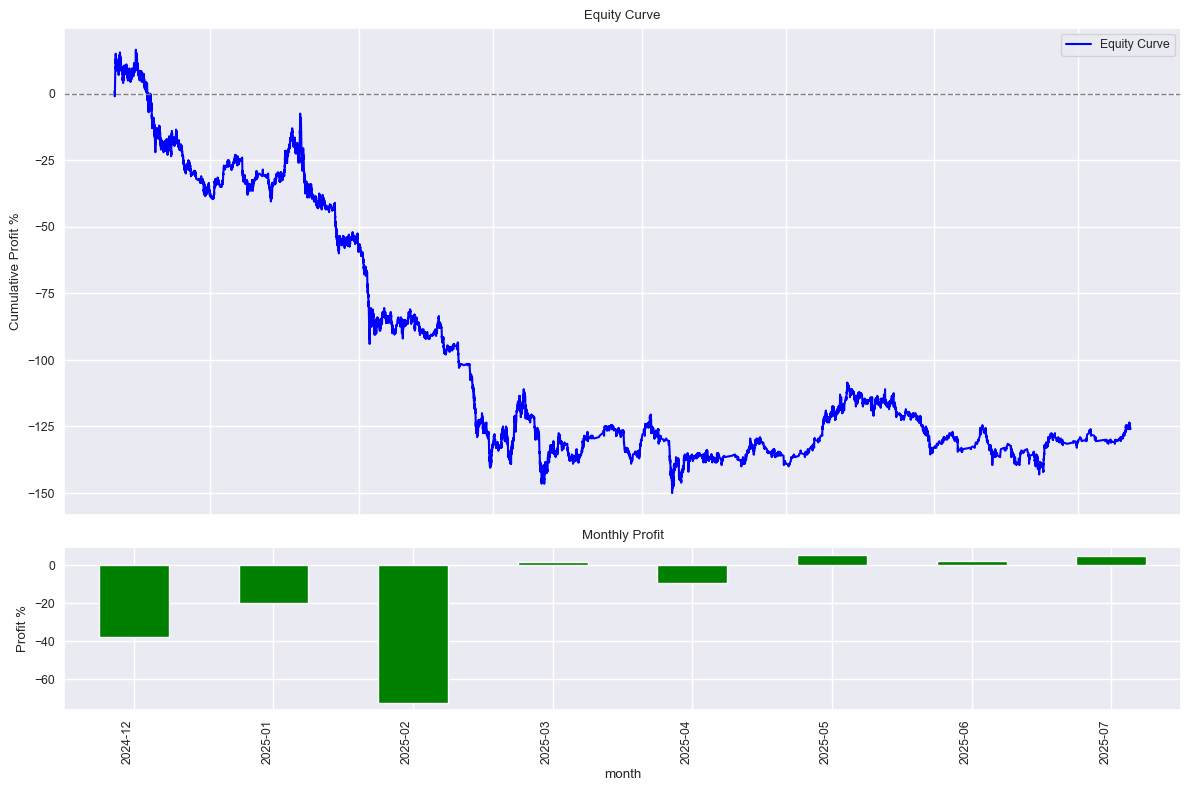

Общая прибыль: -126.0
Количество TP: 7144
Количество SL: 7396
month
2024-12   -38.0
2025-01   -20.0
2025-02   -72.5
2025-03     1.5
2025-04    -9.5
2025-05     5.5
2025-06     2.0
2025-07     5.0
Freq: M, Name: profit_pct, dtype: float64


In [254]:
results = backtest_model_2(df_test, forest, threshold=0.5, tp_pct=0.005, rr=1.0, plot=True)

# Посмотрим результат
print('Общая прибыль:', results['total_profit'])
print('Количество TP:', results['tp_count'])
print('Количество SL:', results['sl_count'])
print(results['monthly_profit'])